**Primero devemos hacer el dataframe necesario, para ello vamos a usar el archivo que nos da palomitacas y limpiarlo.**

In [2]:
import pandas as pd
import os

# --- 1. Definir las rutas de los archivos ---
ruta_archivo_depurado = 'biblioteca_pelis_depurada.csv'

try:
    # --- 2. Cargar el dataset desde el archivo CSV ---
    # Usamos pandas para leer el archivo.
    df = pd.read_csv(r'C:\Users\gonzalo\Desktop\films\biblioteca-peliculas-20250905.csv')

    print(f"Archivo cargado exitosamente. Se encontraron {len(df)} filas.")
    print("Columnas originales:", df.columns.tolist())

    # --- 3. Limpieza de datos ---

    # Paso A: Eliminar filas que son encabezados duplicados
    # A veces, al copiar y pegar, los encabezados se repiten en el cuerpo del archivo.
    # Esta línea elimina cualquier fila donde la columna 'id' contenga el texto 'id'.
    filas_antes = len(df)
    df = df[df['id'] != 'id']
    if len(df) < filas_antes:
        print(f"Se eliminaron {filas_antes - len(df)} filas de encabezados duplicados.")

    # Paso B: Eliminar filas donde 'mi_valoracion' no tiene un valor
    # El método .dropna() elimina las filas con valores nulos (NaN).
    # Usamos el 'subset' para que solo se fije en la columna 'mi_valoracion'.
    filas_antes = len(df)
    df_limpio = df.dropna(subset=['mi_valoracion'])
    print(f"Se eliminaron {filas_antes - len(df_limpio)} filas que no tenían valoración.")

    # Paso C: Quitar las columnas 'id' y 'id_imdb'
    # El método .drop() elimina las columnas especificadas. axis=1 indica que son columnas.
    df_limpio = df_limpio.drop(columns=['id', 'estado', 'tipo', 'fecha_vista'])
    print("Se eliminaron las columnas 'id' y 'id_imdb'.")

    # --- 4. Mostrar resultados y guardar el archivo ---

    print("\n--- Vista previa del dataset depurado ---")
    print(df_limpio.head()) # Muestra las primeras 5 filas del resultado

    print(f"\nEl dataset final tiene {len(df_limpio)} filas y {len(df_limpio.columns)} columnas.")
    print("Columnas finales:", df_limpio.columns.tolist())

    # Guardar el DataFrame depurado en un nuevo archivo CSV
    # index=False evita que pandas añada una columna de índice al archivo.
    df_limpio.to_csv(ruta_archivo_depurado, index=False, encoding='utf-8')

    print(f"\n¡Proceso completado! El dataset depurado ha sido guardado en:\n{os.path.abspath(ruta_archivo_depurado)}")

except FileNotFoundError:
    print(f"Error: No se pudo encontrar el archivo en la ruta especificada: {ruta_archivo_original}")
    print("Por favor, asegúrate de que el archivo exista y la ruta sea correcta.")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

Archivo cargado exitosamente. Se encontraron 407 filas.
Columnas originales: ['id', 'id_imdb', 'titulo', 'estado', 'tipo', 'mi_valoracion', 'fecha_vista']
Se eliminaron 71 filas que no tenían valoración.
Se eliminaron las columnas 'id' y 'id_imdb'.

--- Vista previa del dataset depurado ---
     id_imdb          titulo  mi_valoracion
0  tt1270797           Venom            7.0
1  tt3281548      Mujercitas            9.0
2  tt2948372            Soul            9.0
3  tt1670345    Ahora me ves            9.0
4  tt3110958  Ahora me ves 2            9.0

El dataset final tiene 336 filas y 3 columnas.
Columnas finales: ['id_imdb', 'titulo', 'mi_valoracion']

¡Proceso completado! El dataset depurado ha sido guardado en:
c:\Users\gonzalo\Desktop\portfolio films\biblioteca_pelis_depurada.csv


In [3]:
pelis_depuradas = pd.read_csv(r'C:\Users\gonzalo\Desktop\portfolio films\biblioteca_pelis_depurada.csv')

display(pelis_depuradas.head(10))
print(pelis_depuradas.info())

,id_imdb,titulo,mi_valoracion
0,tt1270797,Venom,7.0
1,tt3281548,Mujercitas,9.0
2,tt2948372,Soul,9.0
3,tt1670345,Ahora me ves,9.0
4,tt3110958,Ahora me ves 2,9.0
5,tt3907584,Violet y Finch,6.5
6,tt1489887,Súper empollonas,7.5
7,tt4925292,Lady Bird,7.5
8,tt10941528,Bajo El Sol De Riccione,7.0
9,tt11698630,Loco por ella,8.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id_imdb        336 non-null    object 
 1   titulo         335 non-null    object 
 2   mi_valoracion  336 non-null    float64
dtypes: float64(1), object(2)
memory usage: 8.0+ KB
None


**Ahora que tenemos los datos vamos a aumentarlos con OMDB a traves de su API**

In [4]:
'''
import pandas as pd
import requests
import time

# 1) Lee tu archivo CSV original
df = pd.read_csv(r'C:\Users\gonzalo\Desktop\portfolio films\biblioteca_pelis_depurada.csv')

# 2) Tu API Key de OMDb
API_KEY = "9385cc9a"

# 3) Función para obtener todos los datos de OMDb usando el id_imdb
def obtener_detalles(imdb_id: str) -> dict:
    url = f"http://www.omdbapi.com/?apikey={API_KEY}&i={imdb_id}&plot=full&r=json"
    resp = requests.get(url)
    if resp.status_code == 200:
        data = resp.json()
        data["id_imdb"] = imdb_id  # añadimos la columna para el merge
        return data
    else:
        # si la llamada falla, devolvemos al menos el id para mantener la fila
        return {"Response": "False", "Error": f"HTTP {resp.status_code}", "id_imdb": imdb_id}

# 4) Consulta para cada id_imdb
detalles = []
for imdb_id in df["id_imdb"]:
    detalles.append(obtener_detalles(imdb_id))
    time.sleep(1)  # evita exceder límites de la API

# 5) Convierte la lista de JSON a DataFrame
detalles_df = pd.DataFrame(detalles)

# 6) Combina los datos originales con los detalles de OMDb usando 'id_imdb'
resultado = df.merge(detalles_df, on="id_imdb", how="left")

# 7) Guarda el nuevo CSV con todos los campos proporcionados por OMDb
resultado.to_csv("biblioteca_peliculas_con_detalles.csv", index=False)

# Impresión de comprobación
print("Primeras filas del resultado combinado:")
display(resultado.head())
print("\n CSV generado: biblioteca_peliculas_con_detalles_full.csv")
'''

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 104-105: truncated \UXXXXXXXX escape (1677480671.py, line 1)

In [5]:
'''# --- BLOQUE DE VERIFICACIÓN ---

# 1. Contar el total de filas
total_filas = len(resultado)

# 2. Contar cuántas tienen Response = 'True'
# Convertimos a string por seguridad, ya que OMDb devuelve "True" (texto)
exitos = resultado[resultado['Response'].astype(str) == 'True'].shape[0]

# 3. Calcular fallos
fallos = total_filas - exitos

print(f"Total de películas enviadas: {total_filas}")
print(f"Respuestas exitosas (True):  {exitos}")
print(f"Respuestas fallidas (False): {fallos}")

# 4. Si hay fallos, mostrar qué películas fueron
if fallos > 0:
    print("\n Películas sin información (Response != True):")
    # Filtramos las filas que no tienen 'True'
    df_fallos = resultado[resultado['Response'].astype(str) != 'True']
    
    # Mostramos solo las columnas relevantes para identificar el error
    cols_a_mostrar = ['id_imdb', 'titulo', 'Response', 'Error']
    # Aseguramos que las columnas existan antes de mostrarlas (por si 'Error' no se generó)
    cols_finales = [c for c in cols_a_mostrar if c in df_fallos.columns]
    
    display(df_fallos[cols_finales])
else:
    print("\nTodo correcto")'''

'# --- BLOQUE DE VERIFICACIÓN ---\n\n# 1. Contar el total de filas\ntotal_filas = len(resultado)\n\n# 2. Contar cuántas tienen Response = \'True\'\n# Convertimos a string por seguridad, ya que OMDb devuelve "True" (texto)\nexitos = resultado[resultado[\'Response\'].astype(str) == \'True\'].shape[0]\n\n# 3. Calcular fallos\nfallos = total_filas - exitos\n\nprint(f"Total de películas enviadas: {total_filas}")\nprint(f"Respuestas exitosas (True):  {exitos}")\nprint(f"Respuestas fallidas (False): {fallos}")\n\n# 4. Si hay fallos, mostrar qué películas fueron\nif fallos > 0:\n    print("\n Películas sin información (Response != True):")\n    # Filtramos las filas que no tienen \'True\'\n    df_fallos = resultado[resultado[\'Response\'].astype(str) != \'True\']\n    \n    # Mostramos solo las columnas relevantes para identificar el error\n    cols_a_mostrar = [\'id_imdb\', \'titulo\', \'Response\', \'Error\']\n    # Aseguramos que las columnas existan antes de mostrarlas (por si \'Error\' no

In [29]:
df = pd.read_csv(r'C:\Users\gonzalo\Desktop\portfolio films\biblioteca_peliculas_con_detalles.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id_imdb        336 non-null    object 
 1   titulo         336 non-null    object 
 2   mi_valoracion  336 non-null    float64
 3   Title          336 non-null    object 
 4   Year           336 non-null    int64  
 5   Rated          323 non-null    object 
 6   Released       336 non-null    object 
 7   Runtime        336 non-null    object 
 8   Genre          336 non-null    object 
 9   Director       336 non-null    object 
 10  Writer         333 non-null    object 
 11  Actors         336 non-null    object 
 12  Plot           336 non-null    object 
 13  Language       336 non-null    object 
 14  Country        336 non-null    object 
 15  Awards         281 non-null    object 
 16  Poster         336 non-null    object 
 17  Ratings        336 non-null    object 
 18  Metascore 

In [30]:
pelis = pd.read_csv(r'C:\Users\gonzalo\Desktop\portfolio films\biblioteca_peliculas_con_detalles.csv')

count= pelis['Response'].values.sum()
print(count, 'responses of' , len(pelis))

pelis = pelis.drop(['titulo', 'Title', 'Poster', 'imdbID', 'Type',
                    'DVD', 'Production', 'Website', 'Response', 'Year'], axis=1)

pelis.info()

336 responses of 336
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id_imdb        336 non-null    object 
 1   mi_valoracion  336 non-null    float64
 2   Rated          323 non-null    object 
 3   Released       336 non-null    object 
 4   Runtime        336 non-null    object 
 5   Genre          336 non-null    object 
 6   Director       336 non-null    object 
 7   Writer         333 non-null    object 
 8   Actors         336 non-null    object 
 9   Plot           336 non-null    object 
 10  Language       336 non-null    object 
 11  Country        336 non-null    object 
 12  Awards         281 non-null    object 
 13  Ratings        336 non-null    object 
 14  Metascore      270 non-null    float64
 15  imdbRating     335 non-null    float64
 16  imdbVotes      336 non-null    object 
 17  BoxOffice      224 non-null    ob

**Ahora toca una EDA a la par que limpiamos el df. A veces se usan modelos lineales y grados y otras no, si están comentados significa que han sido quitados dado a un R2 negativo de millones y se ha suprimido para tener una vision mas realista ya que es un analisis experimental sin HPO**

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import warnings

warnings.filterwarnings('ignore')

# Calculate the value counts for the 'Rated' column
rated_counts = pelis['Rated'].value_counts(normalize=True)

# Identify categories that appear in more than 5% of the movies
rated_to_encode = rated_counts[rated_counts > 0.00].index.tolist()

# Perform one-hot encoding only on the selected 'Rated' categories
rated_dummies_filtered = pd.get_dummies(pelis['Rated'].loc[pelis['Rated'].isin(rated_to_encode)], prefix='Rated')

# Concatenate the new dummy columns to the original DataFrame
pelis_with_dummies_filtered = pd.concat([pelis, rated_dummies_filtered], axis=1)


# Calculate correlations and R-squared for each filtered dummy variable
print("Analysis for One-Hot Encoded 'Rated' column (categories > 0%):")
for column in rated_dummies_filtered.columns:
    # Drop rows with NaN values in the current dummy column and mi_valoracion
    temp_df = pelis_with_dummies_filtered.dropna(subset=[column, 'mi_valoracion']).copy()

    # Ensure the dummy column is numeric
    temp_df[column] = pd.to_numeric(temp_df[column], errors='coerce')

    # Drop any rows that became NaN after coercion
    temp_df.dropna(subset=[column], inplace=True)


    # Calculate correlations
    pearson_corr, _ = pearsonr(temp_df[column], temp_df['mi_valoracion'])
    spearman_corr, _ = spearmanr(temp_df[column], temp_df['mi_valoracion'])

    # Calculate R-squared using linear regression
    model = LinearRegression()
    # Reshape the dummy variable column for the model
    X_single = temp_df[[column]]
    y_single = temp_df['mi_valoracion']
    model.fit(X_single, y_single)
    y_pred_single = model.predict(X_single)
    r2_single = r2_score(y_single, y_pred_single)

    print(f'\nAnalysis for column: {column}')
    print(f'  Pearson correlation: {pearson_corr:.4f}')
    print(f'  Spearman correlation: {spearman_corr:.4f}')
    print(f'  R-squared: {r2_single:.4f}')


# Select features (Rated dummies) and target variable for multiple models
X = pelis_with_dummies_filtered.filter(like='Rated_')
y = pelis_with_dummies_filtered['mi_valoracion']

# Convert boolean columns to numeric (int) and handle potential NaNs
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)
    # Fill any remaining NaNs that might have been introduced during dummy creation
    X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)

# Drop rows with NaN values in X or y
X = X.dropna()
y = y.loc[X.index] # Align y with the filtered X


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression (deg 2)': Pipeline([('polynomialfeatures', PolynomialFeatures(degree=2)), ('linearregression', LinearRegression())]),
    'Polynomial Regression (deg 3)': Pipeline([('polynomialfeatures', PolynomialFeatures(degree=3)), ('linearregression', LinearRegression())]),
    'Polynomial Regression (deg 4)': Pipeline([('polynomialfeatures', PolynomialFeatures(degree=4)), ('linearregression', LinearRegression())]),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1),
}

results = {}
print("\nAnalysis for multiple models using One-Hot Encoded 'Rated' columns:")
# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    results[name] = r2
    print(f'{name} R-squared: {r2:.4f}')

# Calculate average R-squared
average_r2 = sum(results.values()) / len(results)
print(f'\nAverage R-squared: {average_r2:.4f}')

Analysis for One-Hot Encoded 'Rated' column (categories > 0%):

Analysis for column: Rated_18+
  Pearson correlation: 0.0033
  Spearman correlation: 0.0110
  R-squared: 0.0000

Analysis for column: Rated_G
  Pearson correlation: 0.0523
  Spearman correlation: 0.0708
  R-squared: 0.0027

Analysis for column: Rated_Not Rated
  Pearson correlation: 0.0100
  Spearman correlation: -0.0007
  R-squared: 0.0001

Analysis for column: Rated_PG
  Pearson correlation: 0.0516
  Spearman correlation: 0.0293
  R-squared: 0.0027

Analysis for column: Rated_PG-13
  Pearson correlation: 0.0831
  Spearman correlation: 0.1011
  R-squared: 0.0069

Analysis for column: Rated_R
  Pearson correlation: -0.0020
  Spearman correlation: -0.0152
  R-squared: 0.0000

Analysis for column: Rated_TV-14
  Pearson correlation: -0.1003
  Spearman correlation: -0.0971
  R-squared: 0.0101

Analysis for column: Rated_TV-G
  Pearson correlation: -0.1628
  Spearman correlation: -0.0978
  R-squared: 0.0265

Analysis for column

In [9]:
warnings.filterwarnings('ignore')

# Calculate the value counts for the 'Rated' column
rated_counts = pelis['Rated'].value_counts(normalize=True)

# Identify categories that appear in more than 5% of the movies
rated_to_encode = rated_counts[rated_counts > 0.05].index.tolist()

# Perform one-hot encoding only on the selected 'Rated' categories
rated_dummies_filtered = pd.get_dummies(pelis['Rated'].loc[pelis['Rated'].isin(rated_to_encode)], prefix='Rated')

# Concatenate the new dummy columns to the original DataFrame
pelis_with_dummies_filtered = pd.concat([pelis, rated_dummies_filtered], axis=1)


# Calculate correlations and R-squared for each filtered dummy variable
print("Analysis for One-Hot Encoded 'Rated' column (categories > 5%):")
for column in rated_dummies_filtered.columns:
    # Drop rows with NaN values in the current dummy column and mi_valoracion
    temp_df = pelis_with_dummies_filtered.dropna(subset=[column, 'mi_valoracion']).copy()

    # Ensure the dummy column is numeric
    temp_df[column] = pd.to_numeric(temp_df[column], errors='coerce')

    # Drop any rows that became NaN after coercion
    temp_df.dropna(subset=[column], inplace=True)


    # Calculate correlations
    pearson_corr, _ = pearsonr(temp_df[column], temp_df['mi_valoracion'])
    spearman_corr, _ = spearmanr(temp_df[column], temp_df['mi_valoracion'])

    # Calculate R-squared using linear regression
    model = LinearRegression()
    # Reshape the dummy variable column for the model
    X_single = temp_df[[column]]
    y_single = temp_df['mi_valoracion']
    model.fit(X_single, y_single)
    y_pred_single = model.predict(X_single)
    r2_single = r2_score(y_single, y_pred_single)

    print(f'\nAnalysis for column: {column}')
    print(f'  Pearson correlation: {pearson_corr:.4f}')
    print(f'  Spearman correlation: {spearman_corr:.4f}')
    print(f'  R-squared: {r2_single:.4f}')


# Select features (Rated dummies) and target variable for multiple models
X = pelis_with_dummies_filtered.filter(like='Rated_')
y = pelis_with_dummies_filtered['mi_valoracion']

# Convert boolean columns to numeric (int) and handle potential NaNs
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)
    # Fill any remaining NaNs that might have been introduced during dummy creation
    X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)

# Drop rows with NaN values in X or y
X = X.dropna()
y = y.loc[X.index] # Align y with the filtered X


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression (deg 2)': Pipeline([('polynomialfeatures', PolynomialFeatures(degree=2)), ('linearregression', LinearRegression())]),
    'Polynomial Regression (deg 3)': Pipeline([('polynomialfeatures', PolynomialFeatures(degree=3)), ('linearregression', LinearRegression())]),
    'Polynomial Regression (deg 4)': Pipeline([('polynomialfeatures', PolynomialFeatures(degree=4)), ('linearregression', LinearRegression())]),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1),
}

results = {}
print("\nAnalysis for multiple models using One-Hot Encoded 'Rated' columns:")
# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    results[name] = r2
    print(f'{name} R-squared: {r2:.4f}')

# Calculate average R-squared
average_r2 = sum(results.values()) / len(results)
print(f'\nAverage R-squared: {average_r2:.4f}')

Analysis for One-Hot Encoded 'Rated' column (categories > 5%):

Analysis for column: Rated_PG
  Pearson correlation: 0.0510
  Spearman correlation: 0.0284
  R-squared: 0.0026

Analysis for column: Rated_PG-13
  Pearson correlation: 0.0796
  Spearman correlation: 0.1021
  R-squared: 0.0063

Analysis for column: Rated_R
  Pearson correlation: -0.0112
  Spearman correlation: -0.0212
  R-squared: 0.0001

Analysis for column: Rated_TV-14
  Pearson correlation: -0.1101
  Spearman correlation: -0.1035
  R-squared: 0.0121

Analysis for column: Rated_TV-MA
  Pearson correlation: -0.0569
  Spearman correlation: -0.0630
  R-squared: 0.0032

Analysis for multiple models using One-Hot Encoded 'Rated' columns:
Linear Regression R-squared: 0.0062
Polynomial Regression (deg 2) R-squared: 0.0067


Polynomial Regression (deg 3) R-squared: -0.0141
Polynomial Regression (deg 4) R-squared: -0.0053
Lasso R-squared: -0.0117
Ridge R-squared: 0.0080
Decision Tree R-squared: 0.0062
Random Forest R-squared: 0.0101
Extra Trees R-squared: 0.0062
CatBoost R-squared: 0.0062
LightGBM R-squared: 0.0062

Average R-squared: 0.0023


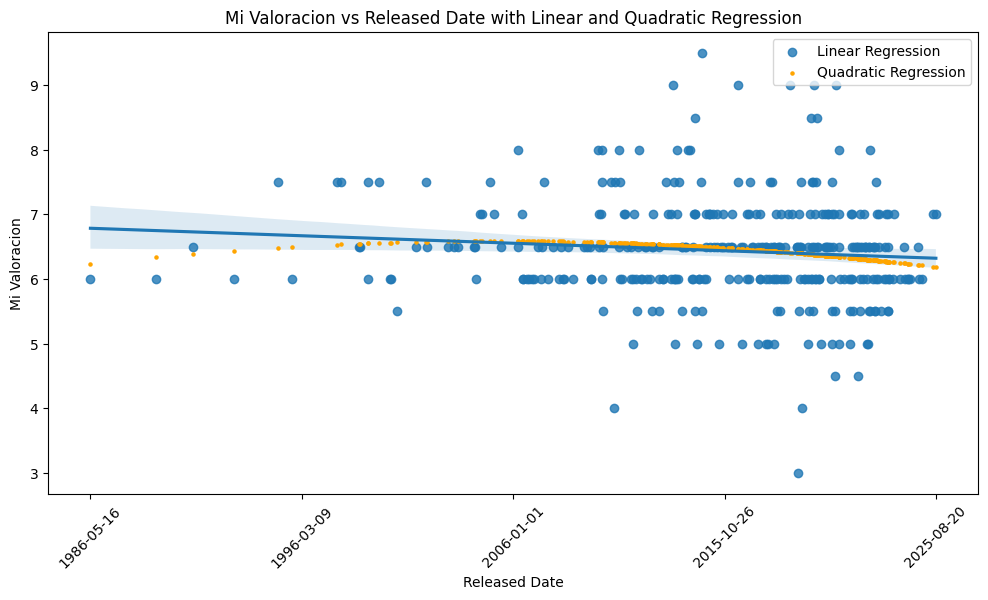

Pearson correlation: -0.0982
Spearman correlation: -0.1187
R-squared for linear regression: 0.0096
R-squared for quadratic regression: 0.0167


In [10]:
import numpy as np

# Convert 'Released' to datetime objects, coercing errors
pelis['Released_datetime'] = pd.to_datetime(pelis['Released'], errors='coerce')

# Drop rows where 'Released' could not be parsed
pelis_released = pelis.dropna(subset=['Released_datetime', 'mi_valoracion']).copy()

# Sort by date for plotting
pelis_released = pelis_released.sort_values(by='Released_datetime')

# Convert datetime to numerical representation for polynomial features and linear regression
pelis_released['Released_numeric'] = (pelis_released['Released_datetime'] - pelis_released['Released_datetime'].min()).dt.days.values.reshape(-1, 1)

# Create scatter plot with linear regression line using numeric date
plt.figure(figsize=(12, 6))
sns.regplot(x='Released_numeric', y='mi_valoracion', data=pelis_released, ci=95, label='Linear Regression')

# Add quadratic regression
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(pelis_released[['Released_numeric']])
poly_reg = LinearRegression()
poly_reg.fit(X_poly, pelis_released['mi_valoracion'])
y_poly_pred = poly_reg.predict(X_poly)

# Plot quadratic regression line
plt.scatter(pelis_released['Released_numeric'], y_poly_pred, color='orange', label='Quadratic Regression', s=5)

# Set x-axis labels to show dates
# Create tick positions and labels based on the original dates
tick_positions = np.linspace(pelis_released['Released_numeric'].min(), pelis_released['Released_numeric'].max(), 5)
tick_labels = [pelis_released['Released_datetime'].min() + pd.Timedelta(days=int(pos)) for pos in tick_positions]
plt.xticks(tick_positions, [label.strftime('%Y-%m-%d') for label in tick_labels], rotation=45)


plt.title('Mi Valoracion vs Released Date with Linear and Quadratic Regression')
plt.xlabel('Released Date')
plt.ylabel('Mi Valoracion')
plt.legend()
plt.show()

# Calculate correlations
pearson_corr, _ = pearsonr(pelis_released['Released_numeric'], pelis_released['mi_valoracion'])
spearman_corr, _ = spearmanr(pelis_released['Released_numeric'], pelis_released['mi_valoracion'])

print(f'Pearson correlation: {pearson_corr:.4f}')
print(f'Spearman correlation: {spearman_corr:.4f}')

# Calculate R-squared for linear regression
linear_model = LinearRegression()
linear_model.fit(pelis_released[['Released_numeric']], pelis_released['mi_valoracion'])
y_linear_pred = linear_model.predict(pelis_released[['Released_numeric']])
r2_linear = r2_score(pelis_released['mi_valoracion'], y_linear_pred)
print(f'R-squared for linear regression: {r2_linear:.4f}')

# Calculate R-squared for quadratic regression
r2_quadratic = r2_score(pelis_released['mi_valoracion'], y_poly_pred)
print(f'R-squared for quadratic regression: {r2_quadratic:.4f}')

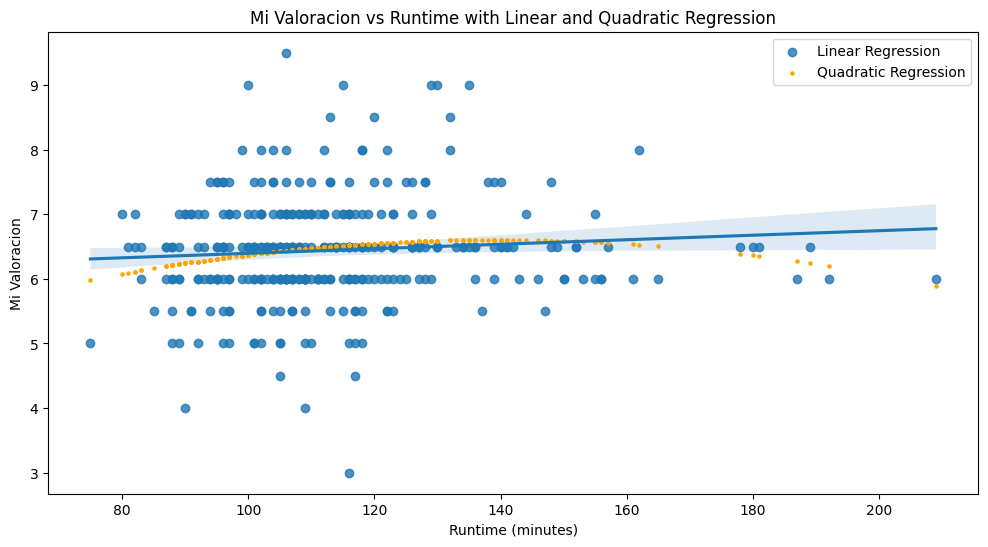

Pearson correlation: 0.0840
Spearman correlation: 0.0968
R-squared for linear regression: 0.0070
R-squared for quadratic regression: 0.0225


In [11]:
# Convert 'Runtime' to numeric, coercing errors and removing ' min'
pelis['Runtime_numeric'] = pelis['Runtime'].str.replace(' min', '', regex=False)
pelis['Runtime_numeric'] = pd.to_numeric(pelis['Runtime_numeric'], errors='coerce')

# Drop rows where 'Runtime' could not be parsed or mi_valoracion is missing
pelis_runtime = pelis.dropna(subset=['Runtime_numeric', 'mi_valoracion']).copy()

# Create scatter plot with linear regression line
plt.figure(figsize=(12, 6))
sns.regplot(x='Runtime_numeric', y='mi_valoracion', data=pelis_runtime, ci=95, label='Linear Regression')

# Add quadratic regression
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(pelis_runtime[['Runtime_numeric']])
poly_reg = LinearRegression()
poly_reg.fit(X_poly, pelis_runtime['mi_valoracion'])
y_poly_pred = poly_reg.predict(X_poly)

# Plot quadratic regression line
plt.scatter(pelis_runtime['Runtime_numeric'], y_poly_pred, color='orange', label='Quadratic Regression', s=5)


plt.title('Mi Valoracion vs Runtime with Linear and Quadratic Regression')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Mi Valoracion')
plt.legend()
plt.show()

# Calculate correlations
pearson_corr, _ = pearsonr(pelis_runtime['Runtime_numeric'], pelis_runtime['mi_valoracion'])
spearman_corr, _ = spearmanr(pelis_runtime['Runtime_numeric'], pelis_runtime['mi_valoracion'])

print(f'Pearson correlation: {pearson_corr:.4f}')
print(f'Spearman correlation: {spearman_corr:.4f}')

# Calculate R-squared for linear regression
linear_model = LinearRegression()
linear_model.fit(pelis_runtime[['Runtime_numeric']], pelis_runtime['mi_valoracion'])
y_linear_pred = linear_model.predict(pelis_runtime[['Runtime_numeric']])
r2_linear = r2_score(pelis_runtime['mi_valoracion'], y_linear_pred)
print(f'R-squared for linear regression: {r2_linear:.4f}')

# Calculate R-squared for quadratic regression
r2_quadratic = r2_score(pelis_runtime['mi_valoracion'], y_poly_pred)
print(f'R-squared for quadratic regression: {r2_quadratic:.4f}')

In [12]:
warnings.filterwarnings('ignore')

# 1. Perform Multi-Hot Encoding for Genre
# Split the 'Genre' string by comma and space, then create dummy variables
genres = pelis['Genre'].str.get_dummies(sep=', ')

# Calculate the count of movies per genre
genre_counts = genres.sum().sort_values(ascending=False)
print("Number of movies per genre:")
print(genre_counts)


# Concatenate the new genre dummy columns to the original DataFrame
pelis_with_genres = pd.concat([pelis, genres], axis=1)


# 2. Analyze Individual Genres
print("\nAnalysis for Individual Genre columns:")
# Exclude the original 'Genre' column and other non-numeric columns if they exist in the dummy part by mistake
genre_columns = genres.columns

for column in genre_columns:
    # Drop rows with NaN values in the current dummy column and mi_valoracion
    temp_df = pelis_with_genres.dropna(subset=[column, 'mi_valoracion']).copy()

    # Ensure the dummy column is numeric (it should be 0 or 1 from get_dummies)
    temp_df[column] = pd.to_numeric(temp_df[column], errors='coerce')

    # Drop any rows that became NaN after coercion (should not happen with get_dummies on clean data)
    temp_df.dropna(subset=[column], inplace=True)


    # Calculate correlations
    pearson_corr, _ = pearsonr(temp_df[column], temp_df['mi_valoracion'])
    spearman_corr, _ = spearmanr(temp_df[column], temp_df['mi_valoracion'])

    # Calculate R-squared using linear regression
    model = LinearRegression()
    # Reshape the dummy variable column for the model
    X_single = temp_df[[column]]
    y_single = temp_df['mi_valoracion']
    model.fit(X_single, y_single)
    y_pred_single = model.predict(X_single)
    r2_single = r2_score(y_single, y_pred_single)

    print(f'\nAnalysis for genre: {column}')
    print(f'  Pearson correlation: {pearson_corr:.4f}')
    print(f'  Spearman correlation: {spearman_corr:.4f}')
    print(f'  R-squared: {r2_single:.4f}')


# 3. Prepare Data for Multiple Models
# Select the multi-hot encoded genre features and the target variable
X_genres = pelis_with_genres[genre_columns]
y_genres = pelis_with_genres['mi_valoracion']

# Ensure all feature columns are numeric and handle potential NaNs (fillna(0) is suitable for dummy variables)
for col in X_genres.columns:
     X_genres[col] = pd.to_numeric(X_genres[col], errors='coerce').fillna(0)

# Drop rows with NaN values in y_genres (X_genres should not have NaNs after fillna)
X_genres = X_genres.loc[y_genres.dropna().index]
y_genres = y_genres.dropna() # Drop NaNs from target variable


# 4. Split Data
X_train_genres, X_test_genres, y_train_genres, y_test_genres = train_test_split(X_genres, y_genres, test_size=0.2, random_state=42)


# 5. Define and Train Multiple Models
models_genres = {
    'Linear Regression': LinearRegression(),
    #'Polynomial Regression (deg 2)': Pipeline([('polynomialfeatures', PolynomialFeatures(degree=2)), ('linearregression', LinearRegression())]),
    #'Polynomial Regression (deg 3)': Pipeline([('polynomialfeatures', PolynomialFeatures(degree=3)), ('linearregression', LinearRegression())]), 
    #'Polynomial Regression (deg 4)': Pipeline([('polynomialfeatures', PolynomialFeatures(degree=4)), ('linearregression', LinearRegression())]),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1),
}

results_genres = {}
print("\nAnalysis for multiple models using Multi-Hot Encoded 'Genre' columns:")
# Train and evaluate models
for name, model in models_genres.items():
    model.fit(X_train_genres, y_train_genres)
    y_pred_genres = model.predict(X_test_genres)
    r2_genres_model = r2_score(y_test_genres, y_pred_genres)
    results_genres[name] = r2_genres_model
    print(f'{name} R-squared: {r2_genres_model:.4f}')

# 7. Calculate Average R-squared for Multiple Models
average_r2_genres = sum(results_genres.values()) / len(results_genres)
print(f'\nAverage R-squared: {average_r2_genres:.4f}')

Number of movies per genre:
Drama          180
Comedy         146
Romance        136
Action          86
Adventure       71
Crime           50
Sci-Fi          31
Thriller        30
Fantasy         21
Biography       20
Animation       20
Mystery         19
Music           11
Sport            7
Family           6
War              5
Horror           4
Documentary      3
Western          3
dtype: int64

Analysis for Individual Genre columns:

Analysis for genre: Action
  Pearson correlation: -0.0083
  Spearman correlation: -0.0091
  R-squared: 0.0001

Analysis for genre: Adventure
  Pearson correlation: 0.0495
  Spearman correlation: 0.0396
  R-squared: 0.0025

Analysis for genre: Animation
  Pearson correlation: 0.0784
  Spearman correlation: 0.0914
  R-squared: 0.0062

Analysis for genre: Biography
  Pearson correlation: 0.0480
  Spearman correlation: 0.0411
  R-squared: 0.0023

Analysis for genre: Comedy
  Pearson correlation: -0.0836
  Spearman correlation: -0.0838
  R-squared: 0.0070


In [13]:
warnings.filterwarnings('ignore')

# 1. Perform Multi-Hot Encoding for Genre
# Split the 'Genre' string by comma and space, then create dummy variables
genres = pelis['Genre'].str.get_dummies(sep=', ')

# Calculate the value counts for each genre
genre_counts = genres.sum().sort_values(ascending=False)

# Identify genres that appear in more than 5% of the movies
total_movies = len(pelis)
genres_to_encode = genre_counts[genre_counts / total_movies > 0.05].index.tolist()

# Filter the genre dummy columns to include only the selected genres
genres_filtered = genres[genres_to_encode]

# Concatenate the new filtered genre dummy columns to the original DataFrame
pelis_with_genres_filtered = pd.concat([pelis, genres_filtered], axis=1)


# 2. Analyze Individual Filtered Genres
print("Analysis for Individual Genre columns (appearing in > 5% of movies):")
genre_columns_filtered = genres_filtered.columns

for column in genre_columns_filtered:
    # Drop rows with NaN values in the current dummy column and mi_valoracion
    temp_df = pelis_with_genres_filtered.dropna(subset=[column, 'mi_valoracion']).copy()

    # Ensure the dummy column is numeric (it should be 0 or 1)
    temp_df[column] = pd.to_numeric(temp_df[column], errors='coerce')

    # Drop any rows that became NaN after coercion
    temp_df.dropna(subset=[column], inplace=True)

    # Calculate correlations
    pearson_corr, _ = pearsonr(temp_df[column], temp_df['mi_valoracion'])
    spearman_corr, _ = spearmanr(temp_df[column], temp_df['mi_valoracion'])

    # Calculate R-squared using linear regression
    model = LinearRegression()
    X_single = temp_df[[column]]
    y_single = temp_df['mi_valoracion']
    model.fit(X_single, y_single)
    y_pred_single = model.predict(X_single)
    r2_single = r2_score(y_single, y_pred_single)

    print(f'\nAnalysis for genre: {column}')
    print(f'  Pearson correlation: {pearson_corr:.4f}')
    print(f'  Spearman correlation: {spearman_corr:.4f}')
    print(f'  R-squared: {r2_single:.4f}')


# 3. Prepare Data for Multiple Models
# Select the filtered multi-hot encoded genre features and the target variable
X_genres_filtered = pelis_with_genres_filtered[genre_columns_filtered]
y_genres_filtered = pelis_with_genres_filtered['mi_valoracion']

# Ensure all feature columns are numeric and handle potential NaNs (fillna(0) is suitable for dummy variables)
for col in X_genres_filtered.columns:
     X_genres_filtered[col] = pd.to_numeric(X_genres_filtered[col], errors='coerce').fillna(0)

# Drop rows with NaN values in y_genres_filtered (X_genres_filtered should not have NaNs after fillna)
X_genres_filtered = X_genres_filtered.loc[y_genres_filtered.dropna().index]
y_genres_filtered = y_genres_filtered.dropna() # Drop NaNs from target variable


# 4. Split Data
X_train_genres_filtered, X_test_genres_filtered, y_train_genres_filtered, y_test_genres_filtered = train_test_split(X_genres_filtered, y_genres_filtered, test_size=0.2, random_state=42)


# 5. Define and Train Multiple Models
models_genres_filtered = {
    'Linear Regression': LinearRegression(),
    #'Polynomial Regression (deg 2)': Pipeline([('polynomialfeatures', PolynomialFeatures(degree=2)), ('linearregression', LinearRegression())]),
    #'Polynomial Regression (deg 3)': Pipeline([('polynomialfeatures', PolynomialFeatures(degree=3)), ('linearregression', LinearRegression())]),
    #'Polynomial Regression (deg 4)': Pipeline([('polynomialfeatures', PolynomialFeatures(degree=4)), ('linearregression', LinearRegression())]),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1),
}

results_genres_filtered = {}
print("\nAnalysis for multiple models using Filtered Multi-Hot Encoded 'Genre' columns:")
# Train and evaluate models
for name, model in models_genres_filtered.items():
    model.fit(X_train_genres_filtered, y_train_genres_filtered)
    y_pred_genres_filtered = model.predict(X_test_genres_filtered)
    r2_genres_model_filtered = r2_score(y_test_genres_filtered, y_pred_genres_filtered)
    results_genres_filtered[name] = r2_genres_model_filtered
    print(f'{name} R-squared: {r2_genres_model_filtered:.4f}')

# 7. Calculate Average R-squared for Multiple Models
average_r2_genres_filtered = sum(results_genres_filtered.values()) / len(results_genres_filtered)
print(f'\nAverage R-squared: {average_r2_genres_filtered:.4f}')

Analysis for Individual Genre columns (appearing in > 5% of movies):

Analysis for genre: Drama
  Pearson correlation: -0.0184
  Spearman correlation: -0.0390
  R-squared: 0.0003

Analysis for genre: Comedy
  Pearson correlation: -0.0836
  Spearman correlation: -0.0838
  R-squared: 0.0070

Analysis for genre: Romance
  Pearson correlation: -0.0814
  Spearman correlation: -0.0679
  R-squared: 0.0066

Analysis for genre: Action
  Pearson correlation: -0.0083
  Spearman correlation: -0.0091
  R-squared: 0.0001

Analysis for genre: Adventure
  Pearson correlation: 0.0495
  Spearman correlation: 0.0396
  R-squared: 0.0025

Analysis for genre: Crime
  Pearson correlation: 0.0394
  Spearman correlation: 0.0429
  R-squared: 0.0016

Analysis for genre: Sci-Fi
  Pearson correlation: 0.0348
  Spearman correlation: 0.0548
  R-squared: 0.0012

Analysis for genre: Thriller
  Pearson correlation: 0.0535
  Spearman correlation: 0.0779
  R-squared: 0.0029

Analysis for genre: Fantasy
  Pearson correlat

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import warnings
from scipy.stats import pearsonr, spearmanr

warnings.filterwarnings('ignore')

# 1. Perform Multi-Hot Encoding for Language
# Handle potential NaN values in 'Language' by replacing them with an empty string
pelis['Language'] = pelis['Language'].fillna('')

# Split the 'Language' string by comma and space, then create dummy variables
languages = pelis['Language'].str.get_dummies(sep=', ')

# Calculate the count of movies per language
language_counts = languages.sum().sort_values(ascending=False)
print("Number of movies per language:")
print(language_counts)

# Concatenate the new language dummy columns to the original DataFrame
pelis_with_languages = pd.concat([pelis, languages], axis=1)


# 2. Analyze Individual Languages
print("\nAnalysis for Individual Language columns:")
# Exclude the original 'Language' column and other non-numeric columns if they exist in the dummy part by mistake
language_columns = languages.columns

for column in language_columns:
    # Drop rows with NaN values in the current dummy column and mi_valoracion
    temp_df = pelis_with_languages.dropna(subset=[column, 'mi_valoracion']).copy()

    # Ensure the dummy column is numeric (it should be 0 or 1 from get_dummies)
    temp_df[column] = pd.to_numeric(temp_df[column], errors='coerce')

    # Drop any rows that became NaN after coercion (should not happen with get_dummies on clean data)
    temp_df.dropna(subset=[column], inplace=True)

    # Check if there's enough data for correlation calculation
    if len(temp_df) > 1:
        # Calculate correlations
        pearson_corr, _ = pearsonr(temp_df[column], temp_df['mi_valoracion'])
        spearman_corr, _ = spearmanr(temp_df[column], temp_df['mi_valoracion'])

        # Calculate R-squared using linear regression
        model = LinearRegression()
        # Reshape the dummy variable column for the model
        X_single = temp_df[[column]]
        y_single = temp_df['mi_valoracion']
        model.fit(X_single, y_single)
        y_pred_single = model.predict(X_single)
        r2_single = r2_score(y_single, y_pred_single)

        print(f'\nAnalysis for language: {column}')
        print(f'  Pearson correlation: {pearson_corr:.4f}')
        print(f'  Spearman correlation: {spearman_corr:.4f}')
        print(f'  R-squared: {r2_single:.4f}')
    else:
        print(f'\nAnalysis for language: {column}')
        print('  Not enough data to calculate correlations and R-squared.')


# 3. Prepare Data for Multiple Models
# Select the multi-hot encoded language features and the target variable
X_languages = pelis_with_languages[language_columns]
y_languages = pelis_with_languages['mi_valoracion']

# Ensure all feature columns are numeric and handle potential NaNs (fillna(0) is suitable for dummy variables)
for col in X_languages.columns:
     X_languages[col] = pd.to_numeric(X_languages[col], errors='coerce').fillna(0)

# Drop rows with NaN values in y_languages (X_languages should not have NaNs after fillna)
X_languages = X_languages.loc[y_languages.dropna().index]
y_languages = y_languages.dropna() # Drop NaNs from target variable


# 4. Split Data
X_train_languages, X_test_languages, y_train_languages, y_test_languages = train_test_split(X_languages, y_languages, test_size=0.2, random_state=42)


# 5. Define and Train Multiple Models
models_languages = {
    #'Linear Regression': LinearRegression(),
    #'Polynomial Regression (deg 2)': Pipeline([('polynomialfeatures', PolynomialFeatures(degree=2)), ('linearregression', LinearRegression())]),

    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1),
}

results_languages = {}
print("\nAnalysis for multiple models using Multi-Hot Encoded 'Language' columns:")
# Train and evaluate models
for name, model in models_languages.items():
    model.fit(X_train_languages, y_train_languages)
    y_pred_languages = model.predict(X_test_languages)
    r2_languages_model = r2_score(y_test_languages, y_pred_languages)
    results_languages[name] = r2_languages_model
    print(f'{name} R-squared: {r2_languages_model:.4f}')

# 6. Calculate Average R-squared for Multiple Models
average_r2_languages = sum(results_languages.values()) / len(results_languages)
print(f'\nAverage R-squared: {average_r2_languages:.4f}')

Number of movies per language:
English                  296
Spanish                   79
French                    50
Italian                   29
German                    24
Mandarin                  18
Japanese                  15
Ukrainian                 11
Portuguese                10
Russian                   10
Korean                     9
Cantonese                  7
Arabic                     6
Swedish                    6
Latin                      5
Chinese                    4
Polish                     3
Xhosa                      3
Hindi                      2
Turkish                    2
Dutch                      2
Czech                      2
Hebrew                     2
Swahili                    2
Greek                      2
Sioux                      1
Shoshoni                   1
Telugu                     1
Tibetan                    1
Serbo-Croatian             1
Sanskrit                   1
Saami                      1
Turkmen                    1
Pawnee      

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import warnings
from scipy.stats import pearsonr, spearmanr

warnings.filterwarnings('ignore')

# 1. Perform Multi-Hot Encoding for Language
# Handle potential NaN values in 'Language' by replacing them with an empty string
pelis['Language'] = pelis['Language'].fillna('')

# Split the 'Language' string by comma and space, then create dummy variables
languages = pelis['Language'].str.get_dummies(sep=', ')

# Calculate the count of movies per language
language_counts = languages.sum().sort_values(ascending=False)
print("Number of movies per language:")
print(language_counts)

# Identify languages that appear in more than 5% of the movies
total_movies = len(pelis)
languages_to_encode = language_counts[language_counts / total_movies > 0.01].index.tolist()

# Filter the language dummy columns to include only the selected languages
languages_filtered = languages[languages_to_encode]

# Concatenate the new filtered language dummy columns to the original DataFrame
pelis_with_languages_filtered = pd.concat([pelis, languages_filtered], axis=1)


# 2. Analyze Individual Filtered Languages
print("\nAnalysis for Individual Language columns (appearing in > 5% of movies):")
language_columns_filtered = languages_filtered.columns

for column in language_columns_filtered:
    # Drop rows with NaN values in the current dummy column and mi_valoracion
    temp_df = pelis_with_languages_filtered.dropna(subset=[column, 'mi_valoracion']).copy()

    # Ensure the dummy column is numeric (it should be 0 or 1)
    temp_df[column] = pd.to_numeric(temp_df[column], errors='coerce')

    # Drop any rows that became NaN after coercion
    temp_df.dropna(subset=[column], inplace=True)

    # Check if there's enough data for correlation calculation
    if len(temp_df) > 1:
        # Calculate correlations
        pearson_corr, _ = pearsonr(temp_df[column], temp_df['mi_valoracion'])
        spearman_corr, _ = spearmanr(temp_df[column], temp_df['mi_valoracion'])

        # Calculate R-squared using linear regression
        model = LinearRegression()
        X_single = temp_df[[column]]
        y_single = temp_df['mi_valoracion']
        model.fit(X_single, y_single)
        y_pred_single = model.predict(X_single)
        r2_single = r2_score(y_single, y_pred_single)

        print(f'\nAnalysis for language: {column}')
        print(f'  Pearson correlation: {pearson_corr:.4f}')
        print(f'  Spearman correlation: {spearman_corr:.4f}')
        print(f'  R-squared: {r2_single:.4f}')
    else:
        print(f'\nAnalysis for language: {column}')
        print('  Not enough data to calculate correlations and R-squared.')


# 3. Prepare Data for Multiple Models
# Select the filtered multi-hot encoded language features and the target variable
X_languages_filtered = pelis_with_languages_filtered[language_columns_filtered]
y_languages_filtered = pelis_with_languages_filtered['mi_valoracion']

# Ensure all feature columns are numeric and handle potential NaNs (fillna(0) is suitable for dummy variables)
for col in X_languages_filtered.columns:
     X_languages_filtered[col] = pd.to_numeric(X_languages_filtered[col], errors='coerce').fillna(0)

# Drop rows with NaN values in y_languages_filtered (X_languages_filtered should not have NaNs after fillna)
X_languages_filtered = X_languages_filtered.loc[y_languages_filtered.dropna().index]
y_languages_filtered = y_languages_filtered.dropna() # Drop NaNs from target variable


# 4. Split Data
X_train_languages_filtered, X_test_languages_filtered, y_train_languages_filtered, y_test_languages_filtered = train_test_split(X_languages_filtered, y_languages_filtered, test_size=0.2, random_state=42)


# 5. Define and Train Multiple Models
models_languages_filtered = {
    'Linear Regression': LinearRegression(),
    #'Polynomial Regression (deg 2)': Pipeline([('polynomialfeatures', PolynomialFeatures(degree=2)), ('linearregression', LinearRegression())]),

    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1),
}

results_languages_filtered = {}
print("\nAnalysis for multiple models using Filtered Multi-Hot Encoded 'Language' columns:")
# Train and evaluate models
for name, model in models_languages_filtered.items():
    model.fit(X_train_languages_filtered, y_train_languages_filtered)
    y_pred_languages_filtered = model.predict(X_test_languages_filtered)
    r2_languages_model_filtered = r2_score(y_test_languages_filtered, y_pred_languages_filtered)
    results_languages_filtered[name] = r2_languages_model_filtered
    print(f'{name} R-squared: {r2_languages_model_filtered:.4f}')

# 6. Calculate Average R-squared for Multiple Models
average_r2_languages_filtered = sum(results_languages_filtered.values()) / len(results_languages_filtered)
print(f'\nAverage R-squared: {average_r2_languages_filtered:.4f}')

Number of movies per language:
English                  296
Spanish                   79
French                    50
Italian                   29
German                    24
Mandarin                  18
Japanese                  15
Ukrainian                 11
Portuguese                10
Russian                   10
Korean                     9
Cantonese                  7
Arabic                     6
Swedish                    6
Latin                      5
Chinese                    4
Polish                     3
Xhosa                      3
Hindi                      2
Turkish                    2
Dutch                      2
Czech                      2
Hebrew                     2
Swahili                    2
Greek                      2
Sioux                      1
Shoshoni                   1
Telugu                     1
Tibetan                    1
Serbo-Croatian             1
Sanskrit                   1
Saami                      1
Turkmen                    1
Pawnee      

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import warnings
from scipy.stats import pearsonr, spearmanr

warnings.filterwarnings('ignore')

# 1. Perform Multi-Hot Encoding for Country
# Handle potential NaN values in 'Country' by replacing them with an empty string
pelis['Country'] = pelis['Country'].fillna('')

# Split the 'Country' string by comma and space, then create dummy variables
countries = pelis['Country'].str.get_dummies(sep=', ')

# Calculate the count of movies per country
country_counts = countries.sum().sort_values(ascending=False)
print("Number of movies per country:")
print(country_counts)

# Concatenate the new country dummy columns to the original DataFrame
pelis_with_countries = pd.concat([pelis, countries], axis=1)


# 2. Analyze Individual Countries
print("\nAnalysis for Individual Country columns:")
# Exclude the original 'Country' column and other non-numeric columns if they exist in the dummy part by mistake
country_columns = countries.columns

for column in country_columns:
    # Drop rows with NaN values in the current dummy column and mi_valoracion
    temp_df = pelis_with_countries.dropna(subset=[column, 'mi_valoracion']).copy()

    # Ensure the dummy column is numeric (it should be 0 or 1 from get_dummies)
    temp_df[column] = pd.to_numeric(temp_df[column], errors='coerce')

    # Drop any rows that became NaN after coercion (should not happen with get_dummies on clean data)
    temp_df.dropna(subset=[column], inplace=True)

    # Check if there's enough data for correlation calculation
    if len(temp_df) > 1:
        # Calculate correlations
        pearson_corr, _ = pearsonr(temp_df[column], temp_df['mi_valoracion'])
        spearman_corr, _ = spearmanr(temp_df[column], temp_df['mi_valoracion'])

        # Calculate R-squared using linear regression
        model = LinearRegression()
        # Reshape the dummy variable column for the model
        X_single = temp_df[[column]]
        y_single = temp_df['mi_valoracion']
        model.fit(X_single, y_single)
        y_pred_single = model.predict(X_single)
        r2_single = r2_score(y_single, y_pred_single)

        print(f'\nAnalysis for country: {column}')
        print(f'  Pearson correlation: {pearson_corr:.4f}')
        print(f'  Spearman correlation: {spearman_corr:.4f}')
        print(f'  R-squared: {r2_single:.4f}')
    else:
        print(f'\nAnalysis for country: {column}')
        print('  Not enough data to calculate correlations and R-squared.')


# 3. Prepare Data for Multiple Models
# Select the multi-hot encoded country features and the target variable
X_countries = pelis_with_countries[country_columns]
y_countries = pelis_with_countries['mi_valoracion']

# Ensure all feature columns are numeric and handle potential NaNs (fillna(0) is suitable for dummy variables)
for col in X_countries.columns:
     X_countries[col] = pd.to_numeric(X_countries[col], errors='coerce').fillna(0)

# Drop rows with NaN values in y_countries (X_countries should not have NaNs after fillna)
X_countries = X_countries.loc[y_countries.dropna().index]
y_countries = y_countries.dropna() # Drop NaNs from target variable


# 4. Split Data
X_train_countries, X_test_countries, y_train_countries, y_test_countries = train_test_split(X_countries, y_countries, test_size=0.2, random_state=42)


# 5. Define and Train Multiple Models
models_countries = {
    #'Linear Regression': LinearRegression(),
    #'Polynomial Regression (deg 2)': Pipeline([('polynomialfeatures', PolynomialFeatures(degree=2)), ('linearregression', LinearRegression())]),

    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1),
}

results_countries = {}
print("\nAnalysis for multiple models using Multi-Hot Encoded 'Country' columns:")
# Train and evaluate models
for name, model in models_countries.items():
    model.fit(X_train_countries, y_train_countries)
    y_pred_countries = model.predict(X_test_countries)
    r2_countries_model = r2_score(y_test_countries, y_pred_countries)
    results_countries[name] = r2_countries_model
    print(f'{name} R-squared: {r2_countries_model:.4f}')

# 6. Calculate Average R-squared for Multiple Models
average_r2_countries = sum(results_countries.values()) / len(results_countries)
print(f'\nAverage R-squared: {average_r2_countries:.4f}')

Number of movies per country:
United States           279
United Kingdom           42
Canada                   33
Spain                    24
France                   21
Germany                  18
Australia                14
Italy                    12
China                    11
Japan                    11
India                     7
Brazil                    6
Belgium                   5
Hong Kong                 5
Mexico                    4
Argentina                 4
New Zealand               3
Taiwan                    2
Hungary                   2
Denmark                   2
Czech Republic            2
Morocco                   2
Turkey                    2
Netherlands               2
Norway                    2
Poland                    2
Thailand                  2
South Korea               2
Austria                   2
Sweden                    2
United Arab Emirates      1
USA                       1
Malta                     1
Romania                   1
Nepal             

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import warnings
from scipy.stats import pearsonr, spearmanr

warnings.filterwarnings('ignore')

# 1. Extract numerical features from 'Awards'
oscars = pelis['Awards'].str.extract('(\d+) Oscar', expand=False)
pelis['Oscars'] = pd.to_numeric(oscars, errors='coerce').fillna(0) # Convert to numeric and fill NaNs with 0

wins = pelis['Awards'].str.extract('(\d+) win[s]?', expand=False)
pelis['Wins'] = pd.to_numeric(wins, errors='coerce').fillna(0) # Convert to numeric and fill NaNs with 0

nominations = pelis['Awards'].str.extract('(\d+) nomination[s]?', expand=False)
pelis['Nominations'] = pd.to_numeric(nominations, errors='coerce').fillna(0) # Convert to numeric and fill NaNs with 0

# Drop the original 'Awards' column
pelis = pelis.drop(['Awards'], axis=1)

# Display info for the new columns
print("Info for extracted Award features:")
pelis[['Oscars', 'Wins', 'Nominations']].info()
print("\nDescriptive statistics for extracted Award features:")
display(pelis[['Oscars', 'Wins', 'Nominations']].describe())


# 2. Analyze Individual Award Features
award_columns = ['Oscars', 'Wins', 'Nominations']
print("\nAnalysis for Individual Award columns:")

for column in award_columns:
    # Drop rows with NaN values in the current award column and mi_valoracion
    temp_df = pelis.dropna(subset=[column, 'mi_valoracion']).copy()

    # Check if there's enough data for correlation calculation
    if len(temp_df) > 1:
        # Calculate correlations
        pearson_corr, _ = pearsonr(temp_df[column], temp_df['mi_valoracion'])
        spearman_corr, _ = spearmanr(temp_df[column], temp_df['mi_valoracion'])

        # Calculate R-squared using linear regression
        model = LinearRegression()
        # Reshape the feature column for the model
        X_single = temp_df[[column]]
        y_single = temp_df['mi_valoracion']
        model.fit(X_single, y_single)
        y_pred_single = model.predict(X_single)
        r2_single = r2_score(y_single, y_pred_single)

        print(f'\nAnalysis for feature: {column}')
        print(f'  Pearson correlation: {pearson_corr:.4f}')
        print(f'  Spearman correlation: {spearman_corr:.4f}')
        print(f'  R-squared: {r2_single:.4f}')
    else:
        print(f'\nAnalysis for feature: {column}')
        print('  Not enough data to calculate correlations and R-squared.')


# 3. Prepare Data for Multiple Models
# Select the extracted award features and the target variable
X_awards = pelis[award_columns]
y_awards = pelis['mi_valoracion']

# Drop rows with NaN values in X_awards or y_awards
X_awards = X_awards.dropna()
y_awards = y_awards.loc[X_awards.index] # Align y with the filtered X_awards


# 4. Split Data
X_train_awards, X_test_awards, y_train_awards, y_test_awards = train_test_split(X_awards, y_awards, test_size=0.2, random_state=42)


# 5. Define and Train Multiple Models
models_awards = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression (deg 2)': Pipeline([('polynomialfeatures', PolynomialFeatures(degree=2)), ('linearregression', LinearRegression())]),

    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1),
}

results_awards = {}
print("\nAnalysis for multiple models using Extracted Award columns:")
# Train and evaluate models
for name, model in models_awards.items():
    model.fit(X_train_awards, y_train_awards)
    y_pred_awards = model.predict(X_test_awards)
    r2_awards_model = r2_score(y_test_awards, y_pred_awards)
    results_awards[name] = r2_awards_model
    print(f'{name} R-squared: {r2_awards_model:.4f}')

# 6. Calculate Average R-squared for Multiple Models
average_r2_awards = sum(results_awards.values()) / len(results_awards)
print(f'\nAverage R-squared: {average_r2_awards:.4f}')

Info for extracted Award features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Oscars       336 non-null    float64
 1   Wins         336 non-null    float64
 2   Nominations  336 non-null    float64
dtypes: float64(3)
memory usage: 8.0 KB

Descriptive statistics for extracted Award features:


,Oscars,Wins,Nominations
count,336.000000,336.000000,336.000000
mean,0.538690,18.839286,37.889881
std,1.276068,41.403703,67.846951
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000
50%,0.000000,2.000000,7.000000
75%,1.000000,11.000000,34.500000
max,10.000000,309.000000,354.000000



Analysis for Individual Award columns:

Analysis for feature: Oscars
  Pearson correlation: 0.1510
  Spearman correlation: 0.1058
  R-squared: 0.0228

Analysis for feature: Wins
  Pearson correlation: 0.1751
  Spearman correlation: 0.1654
  R-squared: 0.0306

Analysis for feature: Nominations
  Pearson correlation: 0.1321
  Spearman correlation: 0.1593
  R-squared: 0.0175

Analysis for multiple models using Extracted Award columns:
Linear Regression R-squared: 0.0110
Polynomial Regression (deg 2) R-squared: 0.0456
Lasso R-squared: -0.0081
Ridge R-squared: 0.0109
Decision Tree R-squared: -0.2921
Random Forest R-squared: -0.0385
Extra Trees R-squared: -0.0265
CatBoost R-squared: 0.0091
LightGBM R-squared: -0.0361

Average R-squared: -0.0361


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import warnings
from scipy.stats import pearsonr, spearmanr
import ast # Import ast to safely evaluate literal expressions

warnings.filterwarnings('ignore')

# 1. Extract and process numerical rating features
if 'Ratings' in pelis.columns:
    def get_RT(ratings_obj):
        # Si viene como string, lo convierte a lista de dicts
        if isinstance(ratings_obj, str):
            try:
                ratings = ast.literal_eval(ratings_obj)
            except (ValueError, SyntaxError):
                return None # Handle cases where string is not a valid list of dicts
            else: # Add this else block to handle successful literal_eval
                 if isinstance(ratings, list):
                    for r in ratings:
                        if isinstance(r, dict) and r.get("Source") == "Rotten Tomatoes":
                            return r.get("Value")
        elif isinstance(ratings_obj, list): # ya es lista
            for r in ratings_obj:
                if isinstance(r, dict) and r.get("Source") == "Rotten Tomatoes":
                    return r.get("Value")
        return None


    RT = pelis["Ratings"].apply(get_RT).str.extract('(\d+)%', expand=False)
    pelis['Rotten Tomatoes'] = pd.to_numeric(RT, errors='coerce').fillna(np.nan) # Convert to numeric and fill NaNs


    def get_MC(ratings_obj):
        # Si viene como string, lo convierte a lista de dicts
        if isinstance(ratings_obj, str):
            try:
                ratings = ast.literal_eval(ratings_obj)
            except (ValueError, SyntaxError):
                return None # Handle cases where string is not a valid list of dicts
            else: # Add this else block to handle successful literal_eval
                 if isinstance(ratings, list):
                    for r in ratings:
                        if isinstance(r, dict) and r.get("Source") == "Metacritic":
                            return r.get("Value")

        elif isinstance(ratings_obj, list): # ya es lista
            for r in ratings_obj:
                if isinstance(r, dict) and r.get("Source") == "Metacritic":
                    return r.get("Value")
        return None

    MC = pelis["Ratings"].apply(get_MC).str.extract('(\d+)/100', expand=False)
    pelis['Metacritic_Score'] = pd.to_numeric(MC, errors='coerce').fillna(np.nan) # Convert to numeric and fill NaNs


# Process BoxOffice
if 'BoxOffice' in pelis.columns:
    pelis['BoxOffice_numeric'] = pelis['BoxOffice'].astype(str).str.replace(',', '', regex=False)
    pelis['BoxOffice_numeric'] = pelis['BoxOffice_numeric'].str.extract('(\d+)', expand=False)
    pelis['BoxOffice_numeric'] = pd.to_numeric(pelis['BoxOffice_numeric'], errors='coerce').fillna(np.nan)

if 'imdbVotes' in pelis.columns:
    # Ensure imdbVotes is numeric if it still exists (it was not dropped in the previous step)
    pelis['imdbVotes_numeric'] = pelis['imdbVotes'].astype(str).str.replace(',', '', regex=False)
    pelis['imdbVotes_numeric'] = pd.to_numeric(pelis['imdbVotes_numeric'], errors='coerce').fillna(np.nan)


# Drop the original 'Ratings', 'BoxOffice', and 'imdbVotes' columns if they exist
columns_to_drop = ['Ratings', 'BoxOffice', 'imdbVotes']
existing_columns_to_drop = [col for col in columns_to_drop if col in pelis.columns]
if existing_columns_to_drop:
    pelis = pelis.drop(existing_columns_to_drop, axis=1)


# Combine all numerical features related to ratings and box office
# Exclude 'BoxOffice_numeric', 'imdbVotes_numeric', and 'Metacritic_Score' as requested
numerical_rating_features = ['Rotten Tomatoes', 'imdbRating', 'Metascore']


# Display info for the selected numerical features
print("Info for selected numerical features:")
pelis[numerical_rating_features].info()
print("\nDescriptive statistics for selected numerical features:")
display(pelis[numerical_rating_features].describe())


# 2. Analyze Individual Numerical Features
print("\nAnalysis for Individual Numerical columns:")

for column in numerical_rating_features:
    # Drop rows with NaN values in the current numerical column and mi_valoracion
    temp_df = pelis.dropna(subset=[column, 'mi_valoracion']).copy()

    # Check if there's enough data for correlation calculation
    if len(temp_df) > 1:
        # Calculate correlations
        pearson_corr, _ = pearsonr(temp_df[column], temp_df['mi_valoracion'])
        spearman_corr, _ = spearmanr(temp_df[column], temp_df['mi_valoracion'])

        # Calculate R-squared using linear regression
        model = LinearRegression()
        # Reshape the feature column for the model
        X_single = temp_df[[column]]
        y_single = temp_df['mi_valoracion']
        model.fit(X_single, y_single)
        y_pred_single = model.predict(X_single)
        r2_single = r2_score(y_single, y_pred_single)

        print(f'\nAnalysis for feature: {column}')
        print(f'  Pearson correlation: {pearson_corr:.4f}')
        print(f'  Spearman correlation: {spearman_corr:.4f}')
        print(f'  R-squared: {r2_single:.4f}')
    else:
        print(f'\nAnalysis for feature: {column}')
        print('  Not enough data to calculate correlations and R-squared.')


# 3. Prepare Data for Multiple Models
# Select the numerical features and the target variable
X_numerical_ratings = pelis[numerical_rating_features]
y_numerical_ratings = pelis['mi_valoracion']

# Drop rows with NaN values in X_numerical_ratings or y_numerical_ratings
# Note: We are dropping rows with NaNs in any of the selected numerical columns for the multi-variate models
combined_df = pd.concat([X_numerical_ratings, y_numerical_ratings], axis=1).dropna()
X_numerical_ratings = combined_df[numerical_rating_features]
y_numerical_ratings = combined_df['mi_valoracion']


# 4. Split Data
X_train_numerical_ratings, X_test_numerical_ratings, y_train_numerical_ratings, y_test_numerical_ratings = train_test_split(X_numerical_ratings, y_numerical_ratings, test_size=0.2, random_state=42)


# 5. Define and Train Multiple Models
models_numerical_ratings = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression (deg 2)': Pipeline([('polynomialfeatures', PolynomialFeatures(degree=2)), ('linearregression', LinearRegression())]),

    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1),
}

results_numerical_ratings = {}
print("\nAnalysis for multiple models using Selected Numerical Rating Features:")
# Train and evaluate models
for name, model in models_numerical_ratings.items():
    model.fit(X_train_numerical_ratings, y_train_numerical_ratings)
    y_pred_numerical_ratings = model.predict(X_test_numerical_ratings)
    r2_numerical_ratings_model = r2_score(y_test_numerical_ratings, y_pred_numerical_ratings)
    results_numerical_ratings[name] = r2_numerical_ratings_model
    print(f'{name} R-squared: {r2_numerical_ratings_model:.4f}')

# 6. Calculate Average R-squared for Multiple Models
average_r2_numerical_ratings = sum(results_numerical_ratings.values()) / len(results_numerical_ratings)
print(f'\nAverage R-squared: {average_r2_numerical_ratings:.4f}')

Info for selected numerical features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rotten Tomatoes  288 non-null    float64
 1   imdbRating       335 non-null    float64
 2   Metascore        270 non-null    float64
dtypes: float64(3)
memory usage: 8.0 KB

Descriptive statistics for selected numerical features:


,Rotten Tomatoes,imdbRating,Metascore
count,288.000000,335.000000,270.000000
mean,64.520833,6.757612,60.559259
std,26.137927,1.026386,16.606595
min,0.000000,3.200000,14.000000
25%,45.000000,6.200000,49.000000
50%,71.000000,6.700000,61.000000
75%,87.000000,7.600000,71.750000
max,100.000000,9.100000,97.000000



Analysis for Individual Numerical columns:

Analysis for feature: Rotten Tomatoes
  Pearson correlation: 0.1176
  Spearman correlation: 0.1246
  R-squared: 0.0138

Analysis for feature: imdbRating
  Pearson correlation: 0.2883
  Spearman correlation: 0.2663
  R-squared: 0.0831

Analysis for feature: Metascore
  Pearson correlation: 0.1598
  Spearman correlation: 0.1257
  R-squared: 0.0255

Analysis for multiple models using Selected Numerical Rating Features:
Linear Regression R-squared: -0.0528
Polynomial Regression (deg 2) R-squared: -0.0926
Lasso R-squared: -0.0051
Ridge R-squared: -0.0509
Decision Tree R-squared: -1.4049
Random Forest R-squared: -0.3041
Extra Trees R-squared: -0.5112
CatBoost R-squared: -0.6557
LightGBM R-squared: -0.3450

Average R-squared: -0.3803


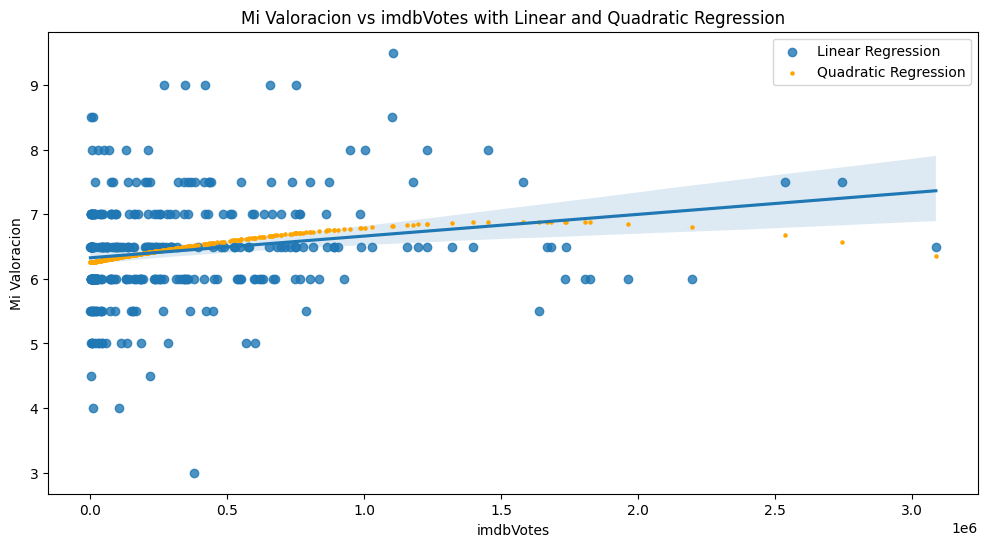

Pearson correlation: 0.1883
Spearman correlation: 0.2168
R-squared for linear regression: 0.0355
R-squared for quadratic regression: 0.0507


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# Check if 'imdbVotes' column exists, otherwise use 'imdbVotes_numeric'
if 'imdbVotes' in pelis.columns:
    # Ensure 'imdbVotes' is numeric, coercing errors and removing commas
    pelis['imdbVotes_numeric'] = pelis['imdbVotes'].astype(str).str.replace(',', '', regex=False)
    pelis['imdbVotes_numeric'] = pd.to_numeric(pelis['imdbVotes_numeric'], errors='coerce')
elif 'imdbVotes_numeric' not in pelis.columns:
     # If neither exists, create a column of NaNs to avoid further errors
     pelis['imdbVotes_numeric'] = np.nan


# Drop rows where 'imdbVotes_numeric' could not be parsed or mi_valoracion is missing
pelis_imdbvotes = pelis.dropna(subset=['imdbVotes_numeric', 'mi_valoracion']).copy()

# Create scatter plot with linear regression line
plt.figure(figsize=(12, 6))
sns.regplot(x='imdbVotes_numeric', y='mi_valoracion', data=pelis_imdbvotes, ci=95, label='Linear Regression')

# Add quadratic regression
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(pelis_imdbvotes[['imdbVotes_numeric']])
poly_reg = LinearRegression()
poly_reg.fit(X_poly, pelis_imdbvotes['mi_valoracion'])
y_poly_pred = poly_reg.predict(X_poly)

# Plot quadratic regression line
plt.scatter(pelis_imdbvotes['imdbVotes_numeric'], y_poly_pred, color='orange', label='Quadratic Regression', s=5)


plt.title('Mi Valoracion vs imdbVotes with Linear and Quadratic Regression')
plt.xlabel('imdbVotes')
plt.ylabel('Mi Valoracion')
plt.legend()
plt.show()

# Calculate correlations
pearson_corr, _ = pearsonr(pelis_imdbvotes['imdbVotes_numeric'], pelis_imdbvotes['mi_valoracion'])
spearman_corr, _ = spearmanr(pelis_imdbvotes['imdbVotes_numeric'], pelis_imdbvotes['mi_valoracion'])

print(f'Pearson correlation: {pearson_corr:.4f}')
print(f'Spearman correlation: {spearman_corr:.4f}')

# Calculate R-squared for linear regression
linear_model = LinearRegression()
linear_model.fit(pelis_imdbvotes[['imdbVotes_numeric']], pelis_imdbvotes['mi_valoracion'])
y_linear_pred = linear_model.predict(pelis_imdbvotes[['imdbVotes_numeric']])
r2_linear = r2_score(pelis_imdbvotes['mi_valoracion'], y_linear_pred)
print(f'R-squared for linear regression: {r2_linear:.4f}')

# Calculate R-squared for quadratic regression
r2_quadratic = r2_score(pelis_imdbvotes['mi_valoracion'], y_poly_pred)
print(f'R-squared for quadratic regression: {r2_quadratic:.4f}')

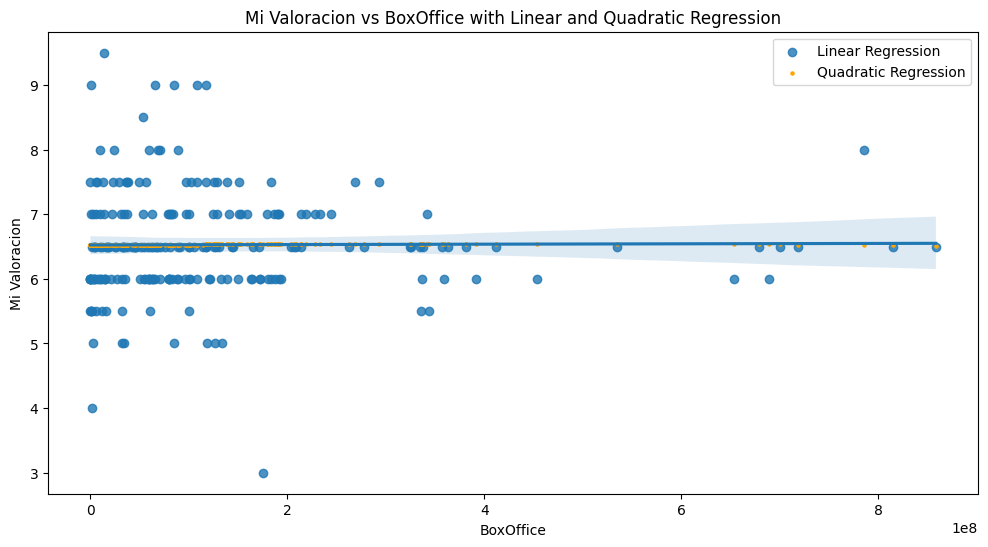

Pearson correlation: 0.0054
Spearman correlation: 0.1052
R-squared for linear regression: 0.0000
R-squared for quadratic regression: 0.0001


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# Check if 'BoxOffice' column exists, otherwise use 'BoxOffice_numeric'
if 'BoxOffice' in pelis.columns:
    # Ensure 'BoxOffice' is numeric, coercing errors and removing commas
    pelis['BoxOffice_numeric'] = pelis['BoxOffice'].astype(str).str.replace(',', '', regex=False)
    pelis['BoxOffice_numeric'] = pelis['BoxOffice_numeric'].str.extract('(\d+)', expand=False)
    pelis['BoxOffice_numeric'] = pd.to_numeric(pelis['BoxOffice_numeric'], errors='coerce')
elif 'BoxOffice_numeric' not in pelis.columns:
     # If neither exists, create a column of NaNs to avoid further errors
     pelis['BoxOffice_numeric'] = np.nan


# Drop rows where 'BoxOffice_numeric' could not be parsed or mi_valoracion is missing
pelis_boxoffice = pelis.dropna(subset=['BoxOffice_numeric', 'mi_valoracion']).copy()

# Create scatter plot with linear regression line
plt.figure(figsize=(12, 6))
sns.regplot(x='BoxOffice_numeric', y='mi_valoracion', data=pelis_boxoffice, ci=95, label='Linear Regression')

# Add quadratic regression
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(pelis_boxoffice[['BoxOffice_numeric']])
poly_reg = LinearRegression()
poly_reg.fit(X_poly, pelis_boxoffice['mi_valoracion'])
y_poly_pred = poly_reg.predict(X_poly)

# Plot quadratic regression line
plt.scatter(pelis_boxoffice['BoxOffice_numeric'], y_poly_pred, color='orange', label='Quadratic Regression', s=5)


plt.title('Mi Valoracion vs BoxOffice with Linear and Quadratic Regression')
plt.xlabel('BoxOffice')
plt.ylabel('Mi Valoracion')
plt.legend()
plt.show()

# Calculate correlations
pearson_corr, _ = pearsonr(pelis_boxoffice['BoxOffice_numeric'], pelis_boxoffice['mi_valoracion'])
spearman_corr, _ = spearmanr(pelis_boxoffice['BoxOffice_numeric'], pelis_boxoffice['mi_valoracion'])

print(f'Pearson correlation: {pearson_corr:.4f}')
print(f'Spearman correlation: {spearman_corr:.4f}')

# Calculate R-squared for linear regression
linear_model = LinearRegression()
linear_model.fit(pelis_boxoffice[['BoxOffice_numeric']], pelis_boxoffice['mi_valoracion'])
y_linear_pred = linear_model.predict(pelis_boxoffice[['BoxOffice_numeric']])
r2_linear = r2_score(pelis_boxoffice['mi_valoracion'], y_linear_pred)
print(f'R-squared for linear regression: {r2_linear:.4f}')

# Calculate R-squared for quadratic regression
r2_quadratic = r2_score(pelis_boxoffice['mi_valoracion'], y_poly_pred)
print(f'R-squared for quadratic regression: {r2_quadratic:.4f}')

**Ahora que hemos hecho el analisis de columnas numericas y las categoricas, vamos a pasar a plot, actor, escritor y director. Para ellos vamos a usar NLP.**

In [31]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
import warnings

warnings.filterwarnings('ignore')

# 1. Load Sentence Transformer Model
model_st = SentenceTransformer("all-mpnet-base-v2")

# 2. Generate Embeddings for Directors
# Generate embeddings for the 'Director' column
pelis_director_embeddings = model_st.encode(pelis['Director'].tolist(), show_progress_bar=True)

# Create a DataFrame from the embeddings
director_cols = [f'director_{i}' for i in range(pelis_director_embeddings.shape[1])]
pelis_director_embeddings_df = pd.DataFrame(pelis_director_embeddings,
                                            index=pelis.index, columns=director_cols)

# Concatenate the embeddings DataFrame with the original DataFrame
pelis = pd.concat([pelis, pelis_director_embeddings_df], axis=1)

# Drop the original 'Director' column
pelis = pelis.drop(['Director'], axis=1)


# 3. Prepare Data for Multiple Models
# Select the director embedding features and the target variable
X_embeddings = pelis.filter(like='director_')
y_embeddings = pelis['mi_valoracion']

# Drop rows with NaN values in y_embeddings
X_embeddings = X_embeddings.loc[y_embeddings.dropna().index]
y_embeddings = y_embeddings.dropna() # Drop NaNs from target variable

# 4. Split Data
X_train_embeddings, X_test_embeddings, y_train_embeddings, y_test_embeddings = train_test_split(X_embeddings, y_embeddings, test_size=0.2, random_state=42)

# 5. Define and Train Multiple Models
models_embeddings = {
    #'Linear Regression': LinearRegression(),
    #'Polynomial Regression (deg 2)': Pipeline([('polynomialfeatures', PolynomialFeatures(degree=2)), ('linearregression', LinearRegression())]),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1),
}

results_embeddings = {}
print("\nAnalysis for multiple models using Director Embeddings:")
# Train and evaluate models
for name, model in models_embeddings.items():
    model.fit(X_train_embeddings, y_train_embeddings)
    y_pred_embeddings = model.predict(X_test_embeddings)
    r2_embeddings_model = r2_score(y_test_embeddings, y_pred_embeddings)
    results_embeddings[name] = r2_embeddings_model
    print(f'{name} R-squared: {r2_embeddings_model:.4f}')

# 6. Calculate Average R-squared for Multiple Models
average_r2_embeddings = sum(results_embeddings.values()) / len(results_embeddings)
print(f'\nAverage R-squared: {average_r2_embeddings:.4f}')

Batches: 100%|██████████| 11/11 [00:03<00:00,  3.43it/s]



Analysis for multiple models using Director Embeddings:
Lasso R-squared: -0.0117
Ridge R-squared: -0.2008
Decision Tree R-squared: -0.5006
Random Forest R-squared: 0.0633
Extra Trees R-squared: -0.0393
CatBoost R-squared: -0.0933
LightGBM R-squared: -0.1153

Average R-squared: -0.1282


In [33]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
import warnings

warnings.filterwarnings('ignore')

# 1. Load Sentence Transformer Model
model_st = SentenceTransformer("all-mpnet-base-v2")

# 2. Generate Embeddings for WRITERS (Guionistas)
# Aseguramos que sea string y rellenamos nulos por si acaso, ya que Writer suele tener más faltantes que Director
pelis['Writer'] = pelis['Writer'].fillna("Unknown").astype(str)

# Generate embeddings for the 'Writer' column
pelis_writer_embeddings = model_st.encode(pelis['Writer'].tolist(), show_progress_bar=True)

# Create a DataFrame from the embeddings
writer_cols = [f'writer_{i}' for i in range(pelis_writer_embeddings.shape[1])]
pelis_writer_embeddings_df = pd.DataFrame(pelis_writer_embeddings,
                                            index=pelis.index, columns=writer_cols)

# Concatenate the embeddings DataFrame with the original DataFrame
pelis = pd.concat([pelis, pelis_writer_embeddings_df], axis=1)

# Drop the original 'Writer' column
pelis = pelis.drop(['Writer'], axis=1)


# 3. Prepare Data for Multiple Models
# Select the writer embedding features and the target variable
X_embeddings = pelis.filter(like='writer_')
y_embeddings = pelis['mi_valoracion']

# Drop rows with NaN values in y_embeddings
X_embeddings = X_embeddings.loc[y_embeddings.dropna().index]
y_embeddings = y_embeddings.dropna() # Drop NaNs from target variable

# 4. Split Data
X_train_embeddings, X_test_embeddings, y_train_embeddings, y_test_embeddings = train_test_split(X_embeddings, y_embeddings, test_size=0.2, random_state=42)

# 5. Define and Train Multiple Models
models_embeddings = {
    #'Linear Regression': LinearRegression(),
    #'Polynomial Regression (deg 2)': Pipeline([('polynomialfeatures', PolynomialFeatures(degree=2)), ('linearregression', LinearRegression())]),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1),
}

results_embeddings = {}
print("\nAnalysis for multiple models using Writer Embeddings:")
# Train and evaluate models
for name, model in models_embeddings.items():
    model.fit(X_train_embeddings, y_train_embeddings)
    y_pred_embeddings = model.predict(X_test_embeddings)
    r2_embeddings_model = r2_score(y_test_embeddings, y_pred_embeddings)
    results_embeddings[name] = r2_embeddings_model
    print(f'{name} R-squared: {r2_embeddings_model:.4f}')

# 6. Calculate Average R-squared for Multiple Models
average_r2_embeddings = sum(results_embeddings.values()) / len(results_embeddings)
print(f'\nAverage R-squared: {average_r2_embeddings:.4f}')

Batches: 100%|██████████| 11/11 [00:05<00:00,  2.11it/s]



Analysis for multiple models using Writer Embeddings:
Lasso R-squared: -0.0117
Ridge R-squared: 0.1100
Decision Tree R-squared: -0.8253
Random Forest R-squared: 0.1237
Extra Trees R-squared: 0.0835
CatBoost R-squared: 0.0680
LightGBM R-squared: 0.0465

Average R-squared: -0.0579


In [34]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
import warnings

warnings.filterwarnings('ignore')

# 1. Load Sentence Transformer Model
model_st = SentenceTransformer("all-mpnet-base-v2")

# 2. Generate Embeddings for ACTORS
# Aseguramos que sea string y rellenamos nulos (importante para evitar errores)
pelis['Actors'] = pelis['Actors'].fillna("Unknown").astype(str)

# Generate embeddings for the 'Actors' column
pelis_actors_embeddings = model_st.encode(pelis['Actors'].tolist(), show_progress_bar=True)

# Create a DataFrame from the embeddings
# Usamos el prefijo 'actor_' para identificar estas columnas
actor_cols = [f'actor_{i}' for i in range(pelis_actors_embeddings.shape[1])]
pelis_actors_embeddings_df = pd.DataFrame(pelis_actors_embeddings,
                                            index=pelis.index, columns=actor_cols)

# Concatenate the embeddings DataFrame with the original DataFrame
pelis = pd.concat([pelis, pelis_actors_embeddings_df], axis=1)

# Drop the original 'Actors' column
pelis = pelis.drop(['Actors'], axis=1)


# 3. Prepare Data for Multiple Models
# Select the actor embedding features and the target variable
X_embeddings = pelis.filter(like='actor_')
y_embeddings = pelis['mi_valoracion']

# Drop rows with NaN values in y_embeddings
X_embeddings = X_embeddings.loc[y_embeddings.dropna().index]
y_embeddings = y_embeddings.dropna() # Drop NaNs from target variable

# 4. Split Data
X_train_embeddings, X_test_embeddings, y_train_embeddings, y_test_embeddings = train_test_split(X_embeddings, y_embeddings, test_size=0.2, random_state=42)

# 5. Define and Train Multiple Models
models_embeddings = {
    #'Linear Regression': LinearRegression(),
    #'Polynomial Regression (deg 2)': Pipeline([('polynomialfeatures', PolynomialFeatures(degree=2)), ('linearregression', LinearRegression())]),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1),
}

results_embeddings = {}
print("\nAnalysis for multiple models using Actors Embeddings:")
# Train and evaluate models
for name, model in models_embeddings.items():
    model.fit(X_train_embeddings, y_train_embeddings)
    y_pred_embeddings = model.predict(X_test_embeddings)
    r2_embeddings_model = r2_score(y_test_embeddings, y_pred_embeddings)
    results_embeddings[name] = r2_embeddings_model
    print(f'{name} R-squared: {r2_embeddings_model:.4f}')

# 6. Calculate Average R-squared for Multiple Models
average_r2_embeddings = sum(results_embeddings.values()) / len(results_embeddings)
print(f'\nAverage R-squared: {average_r2_embeddings:.4f}')

Batches: 100%|██████████| 11/11 [00:07<00:00,  1.38it/s]



Analysis for multiple models using Actors Embeddings:
Lasso R-squared: -0.0117
Ridge R-squared: 0.0687
Decision Tree R-squared: -1.3370
Random Forest R-squared: 0.0185
Extra Trees R-squared: 0.0230
CatBoost R-squared: 0.0884
LightGBM R-squared: -0.0049

Average R-squared: -0.1650


In [35]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
import warnings

warnings.filterwarnings('ignore')

# 1. Load Sentence Transformer Model
model_st = SentenceTransformer("all-mpnet-base-v2")

# 2. Generate Embeddings for PLOT
# Aseguramos que sea string y rellenamos nulos.
# Si no hay trama, ponemos "Unknown" o una cadena vacía.
pelis['Plot'] = pelis['Plot'].fillna("Unknown").astype(str)

# Generate embeddings for the 'Plot' column
pelis_plot_embeddings = model_st.encode(pelis['Plot'].tolist(), show_progress_bar=True)

# Create a DataFrame from the embeddings
# Usamos el prefijo 'plot_' para identificar estas columnas
plot_cols = [f'plot_{i}' for i in range(pelis_plot_embeddings.shape[1])]
pelis_plot_embeddings_df = pd.DataFrame(pelis_plot_embeddings,
                                            index=pelis.index, columns=plot_cols)

# Concatenate the embeddings DataFrame with the original DataFrame
pelis = pd.concat([pelis, pelis_plot_embeddings_df], axis=1)

# Drop the original 'Plot' column
pelis = pelis.drop(['Plot'], axis=1)


# 3. Prepare Data for Multiple Models
# Select the plot embedding features and the target variable
X_embeddings = pelis.filter(like='plot_')
y_embeddings = pelis['mi_valoracion']

# Drop rows with NaN values in y_embeddings
X_embeddings = X_embeddings.loc[y_embeddings.dropna().index]
y_embeddings = y_embeddings.dropna() # Drop NaNs from target variable

# 4. Split Data
X_train_embeddings, X_test_embeddings, y_train_embeddings, y_test_embeddings = train_test_split(X_embeddings, y_embeddings, test_size=0.2, random_state=42)

# 5. Define and Train Multiple Models
models_embeddings = {
    #'Linear Regression': LinearRegression(),
    #'Polynomial Regression (deg 2)': Pipeline([('polynomialfeatures', PolynomialFeatures(degree=2)), ('linearregression', LinearRegression())]),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1),
}

results_embeddings = {}
print("\nAnalysis for multiple models using Plot Embeddings:")
# Train and evaluate models
for name, model in models_embeddings.items():
    model.fit(X_train_embeddings, y_train_embeddings)
    y_pred_embeddings = model.predict(X_test_embeddings)
    r2_embeddings_model = r2_score(y_test_embeddings, y_pred_embeddings)
    results_embeddings[name] = r2_embeddings_model
    print(f'{name} R-squared: {r2_embeddings_model:.4f}')

# 6. Calculate Average R-squared for Multiple Models
average_r2_embeddings = sum(results_embeddings.values()) / len(results_embeddings)
print(f'\nAverage R-squared: {average_r2_embeddings:.4f}')

Batches: 100%|██████████| 11/11 [00:51<00:00,  4.66s/it]



Analysis for multiple models using Plot Embeddings:
Lasso R-squared: -0.0117
Ridge R-squared: 0.0507
Decision Tree R-squared: -1.2017
Random Forest R-squared: -0.0981
Extra Trees R-squared: 0.0075
CatBoost R-squared: 0.0313
LightGBM R-squared: -0.1702

Average R-squared: -0.1989


**Con mini EDA anterior concluimos que ninguna de las caracteristicas por si sola es muy buena, todas tienen un R2 extremadamente bajo y la mayoria negativo, con sobreajustes extremos. Ahora que somos conscientes de la dificultad de este dataset (solo tenemos una 330 filas) vamos a pasar a analisis mas completos y exhaustivos.**

**Primero vamos a crear dos dataframes completos. Uno limpio con embeddings numericos, multi hot encoding etc, y otro especialmente pensado para CatBoost que maneja todo ello de forma autonoma. Para catboost vamos a usar el primero quitando algunas cosas como el id de imdb o el titulo.**

In [47]:
pelis = pd.read_csv(r'C:\Users\gonzalo\Desktop\portfolio films\biblioteca_peliculas_con_detalles.csv')

count= pelis['Response'].values.sum()
print(count, 'responses of' , len(pelis))

pelis = pelis.drop(['titulo', 'Title', 'Poster', 'imdbID', 'Type', 'id_imdb',
                    'DVD', 'Production', 'Website', 'Response', 'Year'], axis=1)

print(pelis.info())
display(pelis.head())

336 responses of 336
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mi_valoracion  336 non-null    float64
 1   Rated          323 non-null    object 
 2   Released       336 non-null    object 
 3   Runtime        336 non-null    object 
 4   Genre          336 non-null    object 
 5   Director       336 non-null    object 
 6   Writer         333 non-null    object 
 7   Actors         336 non-null    object 
 8   Plot           336 non-null    object 
 9   Language       336 non-null    object 
 10  Country        336 non-null    object 
 11  Awards         281 non-null    object 
 12  Ratings        336 non-null    object 
 13  Metascore      270 non-null    float64
 14  imdbRating     335 non-null    float64
 15  imdbVotes      336 non-null    object 
 16  BoxOffice      224 non-null    object 
dtypes: float64(3), object(14)
memory 

,mi_valoracion,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Ratings,Metascore,imdbRating,imdbVotes,BoxOffice
0,7.0,PG-13,05 Oct 2018,112 min,"Action, Adventure, Sci-Fi",Ruben Fleischer,"Jeff Pinkner, Scott Rosenberg, Kelly Marcel","Tom Hardy, Michelle Williams, Riz Ahmed",After a faulty interview with the Life Foundat...,"English, Mandarin, Malay","United States, China",2 wins & 9 nominations total,"[{'Source': 'Internet Movie Database', 'Value'...",35.0,6.6,"590,922","$213,515,506"
1,9.0,PG,25 Dec 2019,135 min,"Drama, Romance",Greta Gerwig,"Greta Gerwig, Louisa May Alcott","Saoirse Ronan, Emma Watson, Florence Pugh","In the years after the Civil War, Jo March (Sa...","English, French",United States,Won 1 Oscar. 73 wins & 230 nominations total,"[{'Source': 'Internet Movie Database', 'Value'...",91.0,7.8,"270,557","$108,101,214"
2,9.0,PG,25 Dec 2020,100 min,"Animation, Adventure, Comedy","Pete Docter, Kemp Powers","Pete Docter, Mike Jones, Kemp Powers","Jamie Foxx, Tina Fey, Graham Norton",Joe is a middle-school band teacher whose life...,"English, Korean, Inuktitut",United States,Won 2 Oscars. 124 wins & 91 nominations total,"[{'Source': 'Internet Movie Database', 'Value'...",83.0,8.0,"417,480","$946,154"
3,9.0,PG-13,31 May 2013,115 min,"Crime, Mystery, Thriller",Louis Leterrier,"Ed Solomon, Boaz Yakin, Edward Ricourt","Jesse Eisenberg, Common, Mark Ruffalo",Four magicians each answer a mysterious summon...,"English, French","United States, France",1 win & 3 nominations total,"[{'Source': 'Internet Movie Database', 'Value'...",50.0,7.2,"750,270","$117,723,989"
4,9.0,PG-13,10 Jun 2016,129 min,"Action, Adventure, Comedy",Jon M. Chu,"Ed Solomon, Peter Chiarelli, Boaz Yakin","Jesse Eisenberg, Mark Ruffalo, Woody Harrelson",One year after outwitting the F.B.I. and winni...,"English, Mandarin, Cantonese","United States, Hong Kong",5 nominations total,"[{'Source': 'Internet Movie Database', 'Value'...",46.0,6.4,"345,960","$65,075,540"


In [48]:
import pandas as pd
import numpy as np
import ast # Para leer el string de la columna Ratings como una lista real
import re  # Para buscar patrones de texto en Awards

pelis = pd.read_csv(r'C:\Users\gonzalo\Desktop\portfolio films\biblioteca_peliculas_con_detalles.csv')

count= pelis['Response'].values.sum()
print(count, 'responses of' , len(pelis))

pelis = pelis.drop(['titulo', 'Title', 'Poster', 'imdbID', 'Type', 'id_imdb',
                    'DVD', 'Production', 'Website', 'Response', 'Year'], axis=1)

# --- 1. Runtime: Convertir a número ---
# Eliminamos " min", convertimos N/A a NaN y pasamos a numérico
pelis['Runtime'] = pelis['Runtime'].astype(str).str.replace(' min', '', regex=False)
pelis['Runtime'] = pd.to_numeric(pelis['Runtime'], errors='coerce')

# --- 2. Released: Extraer solo el año ---
# Convertimos a datetime y extraemos el año
pelis['Released'] = pd.to_datetime(pelis['Released'], errors='coerce')
pelis['Year'] = pelis['Released'].dt.year # Creamos la columna Year
pelis = pelis.drop('Released', axis=1)    # Eliminamos la original Released (opcional)

# --- 3. BoxOffice: Limpiar símbolo $ y comas ---
# Reemplazamos $ y , por nada, y convertimos a numérico
pelis['BoxOffice'] = pelis['BoxOffice'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False)
pelis['BoxOffice'] = pd.to_numeric(pelis['BoxOffice'], errors='coerce')

# --- 4. Awards: Crear 3 columnas (Wins, Nominations, Oscars) ---
def desglosar_awards(texto):
    if pd.isna(texto) or texto == 'N/A':
        return 0, 0, 0
    
    # Buscar patrones numéricos
    # Oscars
    oscars_match = re.search(r'Won (\d+) Oscar', str(texto))
    oscars = int(oscars_match.group(1)) if oscars_match else 0
    
    # Wins (Premios ganados)
    wins_match = re.search(r'(\d+) win', str(texto))
    wins = int(wins_match.group(1)) if wins_match else 0
    
    # Nominations (Nominaciones)
    noms_match = re.search(r'(\d+) nomination', str(texto))
    noms = int(noms_match.group(1)) if noms_match else 0
    
    return oscars, wins, noms

# Aplicamos la función y creamos las columnas nuevas
awards_data = pelis['Awards'].apply(lambda x: desglosar_awards(x))
pelis[['Awards_Oscars', 'Awards_Wins', 'Awards_Nominations']] = pd.DataFrame(awards_data.tolist(), index=pelis.index)

# --- 5. Ratings: Extraer Rotten Tomatoes y Metacritic ---
def extraer_ratings(texto_lista):
    rotten = np.nan
    metacritic = np.nan
    
    try:
        # Convertimos el string "[{'Source':...}]" a una lista real de Python
        lista = ast.literal_eval(texto_lista)
        
        for item in lista:
            if item['Source'] == 'Rotten Tomatoes':
                # Quitamos el % y convertimos a entero
                rotten = int(item['Value'].replace('%', ''))
            elif item['Source'] == 'Metacritic':
                # Quitamos el /100 y convertimos a entero
                metacritic = int(item['Value'].split('/')[0])
    except:
        pass # Si falla o es NaN, se queda como np.nan
        
    return rotten, metacritic

# Aplicamos la función
ratings_data = pelis['Ratings'].apply(lambda x: extraer_ratings(x))
pelis[['RottenTomatoes', 'Metacritic_Extracted']] = pd.DataFrame(ratings_data.tolist(), index=pelis.index)

# Nota: Ya tenías una columna 'Metascore', la nueva 'Metacritic_Extracted' debería ser casi idéntica.
# Puedes borrar la columna 'Ratings' original y 'Awards' original si quieres limpiar visualmente:
pelis = pelis.drop(['Ratings', 'Awards'], axis=1)

# --- Verificación ---
print(pelis.info())
display(pelis.head())


# Guardar el DataFrame limpio a un nuevo CSV
pelis.to_csv('biblioteca_catboost.csv', index=False)

print("Archivo guardado correctamente: biblioteca_catboost.csv")

336 responses of 336
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mi_valoracion         336 non-null    float64
 1   Rated                 323 non-null    object 
 2   Runtime               336 non-null    int64  
 3   Genre                 336 non-null    object 
 4   Director              336 non-null    object 
 5   Writer                333 non-null    object 
 6   Actors                336 non-null    object 
 7   Plot                  336 non-null    object 
 8   Language              336 non-null    object 
 9   Country               336 non-null    object 
 10  Metascore             270 non-null    float64
 11  imdbRating            335 non-null    float64
 12  imdbVotes             336 non-null    object 
 13  BoxOffice             224 non-null    float64
 14  Year                  336 non-null    int32  
 15  Aw

,mi_valoracion,Rated,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Metascore,imdbRating,imdbVotes,BoxOffice,Year,Awards_Oscars,Awards_Wins,Awards_Nominations,RottenTomatoes,Metacritic_Extracted
0,7.0,PG-13,112,"Action, Adventure, Sci-Fi",Ruben Fleischer,"Jeff Pinkner, Scott Rosenberg, Kelly Marcel","Tom Hardy, Michelle Williams, Riz Ahmed",After a faulty interview with the Life Foundat...,"English, Mandarin, Malay","United States, China",35.0,6.6,"590,922",213515506.0,2018,0,2,9,31.0,35.0
1,9.0,PG,135,"Drama, Romance",Greta Gerwig,"Greta Gerwig, Louisa May Alcott","Saoirse Ronan, Emma Watson, Florence Pugh","In the years after the Civil War, Jo March (Sa...","English, French",United States,91.0,7.8,"270,557",108101214.0,2019,1,73,230,95.0,91.0
2,9.0,PG,100,"Animation, Adventure, Comedy","Pete Docter, Kemp Powers","Pete Docter, Mike Jones, Kemp Powers","Jamie Foxx, Tina Fey, Graham Norton",Joe is a middle-school band teacher whose life...,"English, Korean, Inuktitut",United States,83.0,8.0,"417,480",946154.0,2020,2,124,91,95.0,83.0
3,9.0,PG-13,115,"Crime, Mystery, Thriller",Louis Leterrier,"Ed Solomon, Boaz Yakin, Edward Ricourt","Jesse Eisenberg, Common, Mark Ruffalo",Four magicians each answer a mysterious summon...,"English, French","United States, France",50.0,7.2,"750,270",117723989.0,2013,0,1,3,51.0,50.0
4,9.0,PG-13,129,"Action, Adventure, Comedy",Jon M. Chu,"Ed Solomon, Peter Chiarelli, Boaz Yakin","Jesse Eisenberg, Mark Ruffalo, Woody Harrelson",One year after outwitting the F.B.I. and winni...,"English, Mandarin, Cantonese","United States, Hong Kong",46.0,6.4,"345,960",65075540.0,2016,0,0,5,34.0,46.0


Archivo guardado correctamente: biblioteca_catboost.csv


**Y por otro lado el que tendrá todo pero usando encodings y embeddings para que sea puro numero.**

In [65]:
import pandas as pd
import numpy as np
import ast
import re
from sentence_transformers import SentenceTransformer

# 1. Cargar el dataset
pelis = pd.read_csv(r'C:\Users\gonzalo\Desktop\portfolio films\biblioteca_peliculas_con_detalles.csv')

# Verificación inicial
count = pelis['Response'].values.sum()
print(f"{count} responses of {len(pelis)}")

# Eliminamos columnas que no aportan información útil o son redundantes
# Nota: Eliminamos 'Year' original porque lo sacaremos limpio de 'Released'
pelis = pelis.drop(['titulo', 'Title', 'Poster', 'imdbID', 'Type', 'id_imdb',
                    'DVD', 'Production', 'Website', 'Response', 'Year'], axis=1)

print("Dimensiones iniciales:", pelis.shape)

# ==========================================
# PARTE 0: LIMPIEZA DE COLUMNAS COMPLEJAS
# (Runtime, Released, BoxOffice, Awards, Ratings)
# ==========================================
print("Iniciando limpieza de columnas numéricas complejas...")

# 1. Runtime: "112 min" -> 112
pelis['Runtime'] = pelis['Runtime'].astype(str).str.replace(' min', '', regex=False)
pelis['Runtime'] = pd.to_numeric(pelis['Runtime'], errors='coerce')

# 2. Released: Extraer el Año
pelis['Released'] = pd.to_datetime(pelis['Released'], errors='coerce')
pelis['Year_Released'] = pelis['Released'].dt.year
pelis = pelis.drop('Released', axis=1) # Ya no la necesitamos

# 3. BoxOffice: "$213,515,506" -> 213515506
pelis['BoxOffice'] = pelis['BoxOffice'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False)
pelis['BoxOffice'] = pd.to_numeric(pelis['BoxOffice'], errors='coerce')

# 4. imdbVotes: "590,922" -> 590922
if 'imdbVotes' in pelis.columns:
    pelis['imdbVotes'] = pelis['imdbVotes'].astype(str).str.replace(',', '', regex=False)
    pelis['imdbVotes'] = pd.to_numeric(pelis['imdbVotes'], errors='coerce')

# 5. Awards: Extraer Oscars, Wins y Nominations
def desglosar_awards(texto):
    if pd.isna(texto) or texto == 'N/A':
        return 0, 0, 0
    oscars_match = re.search(r'Won (\d+) Oscar', str(texto))
    oscars = int(oscars_match.group(1)) if oscars_match else 0
    wins_match = re.search(r'(\d+) win', str(texto))
    wins = int(wins_match.group(1)) if wins_match else 0
    noms_match = re.search(r'(\d+) nomination', str(texto))
    noms = int(noms_match.group(1)) if noms_match else 0
    return oscars, wins, noms

awards_data = pelis['Awards'].apply(desglosar_awards)
pelis[['Awards_Oscars', 'Awards_Wins', 'Awards_Nominations']] = pd.DataFrame(awards_data.tolist(), index=pelis.index)
pelis = pelis.drop('Awards', axis=1)

# 6. Ratings: Extraer Rotten Tomatoes y Metacritic
def extraer_ratings(texto_lista):
    rotten = np.nan
    metacritic = np.nan
    try:
        lista = ast.literal_eval(texto_lista)
        for item in lista:
            if item['Source'] == 'Rotten Tomatoes':
                rotten = int(item['Value'].replace('%', ''))
            elif item['Source'] == 'Metacritic':
                metacritic = int(item['Value'].split('/')[0])
    except:
        pass
    return rotten, metacritic

ratings_data = pelis['Ratings'].apply(extraer_ratings)
pelis[['RottenTomatoes', 'Metacritic_Extracted']] = pd.DataFrame(ratings_data.tolist(), index=pelis.index)
pelis = pelis.drop('Ratings', axis=1)

# ==========================================
# PARTE 1: MULTI-HOT ENCODING
# (Rated, Genre, Language, Country)
# ==========================================

cols_to_multihot = {
    'Rated': 'rated',
    'Genre': 'genre',
    'Language': 'lang',
    'Country': 'country'
}

for col, prefix in cols_to_multihot.items():
    print(f"Procesando Multi-hot: {col}...")
    s = pelis[col].fillna('Unknown').astype(str)
    dummies = s.str.get_dummies(sep=', ')
    dummies = dummies.add_prefix(f'{prefix}_')
    pelis = pd.concat([pelis, dummies], axis=1)
    pelis = pelis.drop(col, axis=1)

# ==========================================
# PARTE 2: NLP EMBEDDINGS
# (Director, Writer, Actors, Plot)
# ==========================================

model_st = SentenceTransformer("all-mpnet-base-v2")

cols_to_embed = {
    'Director': 'director',
    'Writer': 'writer',
    'Actors': 'actor',
    'Plot': 'plot'
}

for col, prefix in cols_to_embed.items():
    print(f"Generando Embeddings: {col}...")
    textos = pelis[col].fillna("Unknown").astype(str).tolist()
    embeddings = model_st.encode(textos, show_progress_bar=True)
    col_names = [f'{prefix}_{i}' for i in range(embeddings.shape[1])]
    emb_df = pd.DataFrame(embeddings, index=pelis.index, columns=col_names)
    pelis = pd.concat([pelis, emb_df], axis=1)
    pelis = pelis.drop(col, axis=1)

# ==========================================
# PARTE 3: VERIFICACIÓN FINAL Y GUARDADO
# ==========================================

print("\nDimensiones finales:", pelis.shape)
print("Tipos de datos restantes (deberían ser todos int/float):")

non_numeric = pelis.select_dtypes(exclude=['number']).columns
if len(non_numeric) > 0:
    print("⚠️ Atención, quedan columnas no numéricas:", non_numeric)
    # Si queda alguna columna object residual, la mostramos para decidir
    print(pelis[non_numeric].head())
else:
    print("✅ Todo el dataset es numérico.")

# Guardar
pelis.to_csv('biblioteca_numerica_completa.csv', index=False)
print("\nArchivo guardado: biblioteca_numerica_completa.csv")

336 responses of 336
Dimensiones iniciales: (336, 17)
Iniciando limpieza de columnas numéricas complejas...
Procesando Multi-hot: Rated...
Procesando Multi-hot: Genre...
Procesando Multi-hot: Language...
Procesando Multi-hot: Country...
Generando Embeddings: Director...


Batches: 100%|██████████| 11/11 [00:03<00:00,  3.35it/s]


Generando Embeddings: Writer...


Batches: 100%|██████████| 11/11 [00:04<00:00,  2.32it/s]


Generando Embeddings: Actors...


Batches: 100%|██████████| 11/11 [00:06<00:00,  1.69it/s]


Generando Embeddings: Plot...


Batches: 100%|██████████| 11/11 [00:49<00:00,  4.48s/it]



Dimensiones finales: (336, 3211)
Tipos de datos restantes (deberían ser todos int/float):
✅ Todo el dataset es numérico.

Archivo guardado: biblioteca_numerica_completa.csv


**Ahora que tenemos ambos datasets nos vamos a centrar principalmente en el segundo y que es mas facil de usar en varios modelos. Como tenemos una cantidad inmensa de features en comparacion a la cantidad de datos vamos a dividir en subsets, que serán: rated, genre, languaje y country para usar RFE con PFI. Para los embeddings, director, escritor, actor y plot usaremos reduccion de dimensionalidad con PCA (he probado tambien UMAP pero considero mejor PCA)**

**Pero con lo anterior tenemos el problema de que quizas las features del genero no son utiles entre ellas pero si lo son en conjunto con el actor. No se preocupe, mas a delante abordaremos eso.**

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import warnings

warnings.filterwarnings('ignore')

# =============================================================================
# 1. CARGA Y FILTRADO DE DATOS
# =============================================================================

df = pd.read_csv(r'C:\Users\gonzalo\Desktop\portfolio films\biblioteca_numerica_completa.csv')

# Prefijos de los subsets que nos interesan
subsets_prefixes = ['rated_', 'genre_', 'lang_', 'country_']

# Identificar todas las columnas que pertenecen a estos subsets
cols_to_keep = []
for col in df.columns:
    if any(col.startswith(prefix) for prefix in subsets_prefixes):
        cols_to_keep.append(col)

# Añadimos el target
cols_to_keep.append('mi_valoracion')

# Filtramos el DF (Droppeamos embeddings y numéricas base)
df_subsets = df[cols_to_keep].copy()

print(f"Dimensiones originales: {df.shape}")
print(f"Dimensiones para análisis de subsets: {df_subsets.shape}")

# Separar X e y
X = df_subsets.drop('mi_valoracion', axis=1)
y = df_subsets['mi_valoracion']

# Split Train/Test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalado (Importante para mantener consistencia)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# =============================================================================
# 2. FUNCIÓN RFE CON PFI (Permutation Feature Importance)
# =============================================================================

def analyze_subset_rfe_pfi(X_subset, y_subset, subset_name):
    """
    Ejecuta RFE usando PFI para determinar el número óptimo de features.
    Devuelve el mejor score y la lista de features óptima.
    """
    # Modelo "Juez" para seleccionar features. 
    # Usamos RF porque captura relaciones no lineales mejor que Lasso/Ridge para la selección.
    model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
    
    features_current = list(X_subset.columns)
    history = [] # Guardará (n_features, r2_score, features_list)
    
    print(f"\n--- Analizando Subset: {subset_name.upper()} ({len(features_current)} features iniciales) ---")
    
    while len(features_current) > 0:
        X_curr = X_subset[features_current]
        
        # 1. Validación Cruzada (5 Folds) para obtener métrica robusta (R2)
        # Si hay muy pocas filas/cols, a veces da error, protegemos con try/except
        try:
            cv_scores = cross_val_score(model, X_curr, y_subset, cv=5, scoring='r2')
            mean_r2 = cv_scores.mean()
        except:
            mean_r2 = -999 # Fallo técnico
            
        history.append({
            'n_features': len(features_current),
            'r2': mean_r2,
            'features': features_current.copy()
        })
        
        if len(features_current) == 1:
            break
            
        # 2. Calcular PFI
        model.fit(X_curr, y_subset)
        result = permutation_importance(model, X_curr, y_subset, n_repeats=5, random_state=42, n_jobs=-1)
        
        # 3. Eliminar la peor feature (menor importancia)
        worst_idx = np.argmin(result.importances_mean)
        removed = features_current.pop(worst_idx)
        
        # Print ligero para seguimiento
        if len(features_current) % 5 == 0:
            print(f"   > {len(features_current)} features restantes. R2 actual: {mean_r2:.4f}")

    # Buscar el punto óptimo (Máximo R2)
    best_step = max(history, key=lambda x: x['r2'])
    
    print(f"✅ ÓPTIMO para {subset_name}: {best_step['n_features']} features (R2: {best_step['r2']:.4f})")
    return best_step['features'], history

# =============================================================================
# 3. EJECUCIÓN POR SUBSETS
# =============================================================================

optimal_features_dict = {}

for prefix in subsets_prefixes:
    # Extraer columnas del subset actual
    cols_subset = [c for c in X_train_scaled.columns if c.startswith(prefix)]
    
    if len(cols_subset) == 0:
        print(f"⚠️ No hay columnas para {prefix}")
        continue
        
    # Ejecutar análisis
    best_feats, hist = analyze_subset_rfe_pfi(X_train_scaled[cols_subset], y_train, prefix)
    
    # Guardar resultados
    optimal_features_dict[prefix] = best_feats
    
    # (Opcional) Mostrar las features ganadoras
    print(f"   Features seleccionadas: {best_feats}")

# =============================================================================
# 4. GUARDAR RESULTADOS
# =============================================================================

print("\nResumen de optimización:")
total_feats = 0
for k, v in optimal_features_dict.items():
    print(f"- {k}: {len(v)} features seleccionadas.")
    total_feats += len(v)

print(f"\nTotal de features para entrenar modelos finales: {total_feats}")

# Guardamos la lista de columnas óptimas en una variable para el siguiente paso
# (Entrenar Lasso, Ridge, etc.)
final_selected_columns = []
for feats in optimal_features_dict.values():
    final_selected_columns.extend(feats)

Dimensiones originales: (336, 3203)
Dimensiones para análisis de subsets: (336, 128)

--- Analizando Subset: RATED_ (12 features iniciales) ---
   > 10 features restantes. R2 actual: -0.1575
   > 5 features restantes. R2 actual: -0.0643
✅ ÓPTIMO para rated_: 2 features (R2: -0.0351)
   Features seleccionadas: ['rated_TV-14', 'rated_TV-G']

--- Analizando Subset: GENRE_ (19 features iniciales) ---
   > 15 features restantes. R2 actual: -0.2244
   > 10 features restantes. R2 actual: -0.1990
   > 5 features restantes. R2 actual: -0.1084
✅ ÓPTIMO para genre_: 1 features (R2: -0.0527)
   Features seleccionadas: ['genre_Horror']

--- Analizando Subset: LANG_ (56 features iniciales) ---
   > 55 features restantes. R2 actual: -0.1761
   > 50 features restantes. R2 actual: -0.1611
   > 45 features restantes. R2 actual: -0.1660
   > 40 features restantes. R2 actual: -0.1688
   > 35 features restantes. R2 actual: -0.1586
   > 30 features restantes. R2 actual: -0.1535
   > 25 features restantes. R

**Vale ahora tenemos features que son robustas. Pera comprobar si este proceso realmente a ayudado vamos a comparar varios modelos con esas 15 features y otros con las 128 iniciales.**

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error

# =============================================================================
# 1. PREPARACIÓN DE LOS DATASETS (FULL vs OPTIMIZED)
# =============================================================================

# A) Definir las listas de columnas
# ----------------------------------

# 1. Lista OPTIMIZADA (Copiada de tu output anterior)
opt_feats = [
    'rated_TV-14', 'rated_TV-G',                                      # Rated
    'genre_Horror',                                                   # Genre
    'lang_French', 'lang_Korean', 'lang_Mandarin', 'lang_Russian',    # Lang
    'country_Australia', 'country_Denmark', 'country_Germany',        # Country
    'country_Hong Kong', 'country_India', 'country_Romania', 
    'country_United Kingdom', 'country_United States'
]

# 2. Lista COMPLETA (Todas las que empiezan por los prefijos)
subsets_prefixes = ['rated_', 'genre_', 'lang_', 'country_']
full_feats = [c for c in X_train_scaled.columns if any(c.startswith(p) for p in subsets_prefixes)]

print(f"Features en set COMPLETO: {len(full_feats)}")
print(f"Features en set OPTIMIZADO: {len(opt_feats)}")

# B) Crear los diccionarios de datos para iterar
# ----------------------------------------------
datasets = {
    "FULL (128 feats)": (X_train_scaled[full_feats], X_test_scaled[full_feats]),
    "OPT (15 feats)":   (X_train_scaled[opt_feats], X_test_scaled[opt_feats])
}

# =============================================================================
# 2. CONFIGURACIÓN DE MODELOS
# =============================================================================

# Definimos los modelos. Para Lasso y Ridge incluimos ya el GridSearch
models_config = {
    'Lasso (HPO)': GridSearchCV(
        Lasso(random_state=42, max_iter=10000), 
        {'alpha': [0.001, 0.01, 0.1, 0.5, 1, 5, 10]}, 
        cv=5, scoring='r2'
    ),
    'Ridge (HPO)': GridSearchCV(
        Ridge(random_state=42), 
        {'alpha': [0.1, 1, 10, 50, 100, 500]}, 
        cv=5, scoring='r2'
    ),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10), # Limitamos profundidad para evitar overfitting extremo
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Extra Trees': ExtraTreesRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'SVR': SVR(kernel='rbf', C=1.0, epsilon=0.1)
}

# =============================================================================
# 3. BUCLE DE ENTRENAMIENTO Y EVALUACIÓN
# =============================================================================

results_list = []

print("\nIniciando comparativa de modelos...\n")

for dataset_name, (X_tr, X_te) in datasets.items():
    print(f"--- Procesando: {dataset_name} ---")
    
    for model_name, model in models_config.items():
        # 1. Entrenar
        model.fit(X_tr, y_train)
        
        # Si es GridSearch, extraemos el mejor estimador para predecir (aunque predict lo hace auto)
        if isinstance(model, GridSearchCV):
            best_params = model.best_params_
            final_model = model.best_estimator_
            model_label = f"{model_name} [Best: {best_params}]"
        else:
            final_model = model
            model_label = model_name
            
        # 2. Predecir en Test
        y_pred = final_model.predict(X_te)
        
        # 3. Calcular Métricas
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        
        # Correlación (Pearson)
        # np.corrcoef devuelve matriz, cogemos [0,1]. Si es constante devuelve NaN, controlamos eso.
        try:
            corr = np.corrcoef(y_test, y_pred)[0, 1]
        except:
            corr = 0
            
        # Ratio R2/MSE (Cuidado si MSE es 0 o R2 negativo)
        ratio = r2 / mse if mse != 0 else 0
        
        # 4. Guardar
        results_list.append({
            'Dataset': dataset_name,
            'Model': model_label,
            'R2': r2,
            'MSE': mse,
            'Correlation': corr,
            'R2/MSE Ratio': ratio
        })

# =============================================================================
# 4. VISUALIZACIÓN DE RESULTADOS
# =============================================================================

results_df = pd.DataFrame(results_list)

# Ordenamos para ver primero los mejores R2
results_df = results_df.sort_values(by='R2', ascending=False)

print("\n=== TABLA COMPARATIVA DE RESULTADOS (TEST SET) ===")
display(results_df)

# Comparativa directa agrupada por modelo
print("\n=== COMPARATIVA DIRECTA (Diferencia R2: OPT - FULL) ===")
pivot_df = results_df.pivot(index='Model', columns='Dataset', values='R2')
pivot_df['Diff (Opt - Full)'] = pivot_df['OPT (15 feats)'] - pivot_df['FULL (128 feats)']
display(pivot_df.sort_values('Diff (Opt - Full)', ascending=False))

Features en set COMPLETO: 127
Features en set OPTIMIZADO: 15

Iniciando comparativa de modelos...

--- Procesando: FULL (128 feats) ---
--- Procesando: OPT (15 feats) ---

=== TABLA COMPARATIVA DE RESULTADOS (TEST SET) ===


,Dataset,Model,R2,MSE,Correlation,R2/MSE Ratio
1,FULL (128 feats),Ridge (HPO) [Best: {'alpha': 500}],0.009945,0.705928,0.126404,0.014088
0,FULL (128 feats),Lasso (HPO) [Best: {'alpha': 0.5}],-0.011665,0.721336,NaN,-0.016171
7,OPT (15 feats),Ridge (HPO) [Best: {'alpha': 100}],-0.015138,0.723813,0.098431,-0.020915
5,FULL (128 feats),SVR,-0.023443,0.729734,0.095358,-0.032125
11,OPT (15 feats),SVR,-0.033543,0.736936,0.081030,-0.045517
2,FULL (128 feats),Decision Tree,-0.034379,0.737532,0.207093,-0.046614
6,OPT (15 feats),Lasso (HPO) [Best: {'alpha': 0.01}],-0.046417,0.746115,0.084960,-0.062211
8,OPT (15 feats),Decision Tree,-0.072682,0.764842,0.102964,-0.095028
3,FULL (128 feats),Random Forest,-0.085402,0.773912,0.135194,-0.110350
9,OPT (15 feats),Random Forest,-0.122712,0.800515,0.072774,-0.153291



=== COMPARATIVA DIRECTA (Diferencia R2: OPT - FULL) ===


Dataset,FULL (128 feats),OPT (15 feats),Diff (Opt - Full)
Model,,,
Extra Trees,-0.429241,-0.134787,0.294453
SVR,-0.023443,-0.033543,-0.010100
Random Forest,-0.085402,-0.122712,-0.037311
Decision Tree,-0.034379,-0.072682,-0.038302
Lasso (HPO) [Best: {'alpha': 0.01}],NaN,-0.046417,NaN
Lasso (HPO) [Best: {'alpha': 0.5}],-0.011665,NaN,NaN
Ridge (HPO) [Best: {'alpha': 100}],NaN,-0.015138,NaN
Ridge (HPO) [Best: {'alpha': 500}],0.009945,NaN,NaN


**Como vemos las features escogidas son peores que usar todas por lo que ahora vamos a provar algunas cosas con los embeddings.**

**Tambien vamos a dividir los embeddings en director, escritor, actor y plot y vamos a usar KNN con HPO ya que al ser de una dimensionalidad tan alta hay overfit en practicamente todos los modelos.**

In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error

# =============================================================================
# 1. CARGA DE DATOS
# =============================================================================

df = pd.read_csv(r'C:\Users\gonzalo\Desktop\portfolio films\biblioteca_numerica_completa.csv')

# Separamos Target
y = df['mi_valoracion']

# Definimos los grupos de embeddings a analizar
embedding_groups = ['director_', 'writer_', 'actor_', 'plot_']

# =============================================================================
# 2. CONFIGURACIÓN DEL HPO PARA KNN
# =============================================================================

# Parámetros a probar en GridSearch
# - n_neighbors: Cuántos vecinos mirar (clave para evitar overfitting)
# - weights: 'uniform' (todos votan igual) vs 'distance' (los más cercanos influyen más)
# - metric: 'cosine' es ESTÁNDAR para embeddings, 'euclidean' es la clásica
knn_params = {
    'n_neighbors': [3, 5, 7, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200, 225, 250, 275, 300],
    'weights': ['uniform', 'distance'],
    'metric': ['cosine', 'euclidean'] 
}

results_list = []

print("Iniciando análisis de Embeddings con KNN + HPO...\n")

# =============================================================================
# 3. BUCLE POR GRUPO DE EMBEDDINGS
# =============================================================================

for prefix in embedding_groups:
    print(f"--- Procesando Embeddings: {prefix.upper().replace('_', '')} ---")
    
    # 1. Filtrar columnas del grupo actual
    cols = [c for c in df.columns if c.startswith(prefix)]
    X_subset = df[cols]
    
    # 2. Split Train/Test (Mismo random_state para comparar peras con peras)
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42)
    
    # 3. GridSearch con KNN
    knn = KNeighborsRegressor()
    gs = GridSearchCV(knn, knn_params, cv=5, scoring='r2', n_jobs=-1)
    gs.fit(X_train, y_train)
    
    # 4. Mejor modelo y predicción
    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # 5. Métricas
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # Correlación
    try:
        corr = np.corrcoef(y_test, y_pred)[0, 1]
    except:
        corr = 0
        
    # Ratio
    ratio = r2 / mse if mse != 0 else 0
    
    # Guardar resultados
    results_list.append({
        'Embedding Subset': prefix.replace('_', '').capitalize(),
        'Best Params': gs.best_params_,
        'Best CV R2': gs.best_score_, # R2 promedio en validación cruzada (Train)
        'Test R2': r2,                # R2 en Test set
        'Test MSE': mse,
        'Correlation': corr,
        'R2/MSE Ratio': ratio
    })

# =============================================================================
# 4. RESULTADOS
# =============================================================================

results_df = pd.DataFrame(results_list).sort_values(by='Test R2', ascending=False)

print("\n=== RESULTADOS KNN EN EMBEDDINGS ===")
display(results_df)

Iniciando análisis de Embeddings con KNN + HPO...

--- Procesando Embeddings: DIRECTOR ---
--- Procesando Embeddings: WRITER ---
--- Procesando Embeddings: ACTOR ---
--- Procesando Embeddings: PLOT ---

=== RESULTADOS KNN EN EMBEDDINGS ===


,Embedding Subset,Best Params,Best CV R2,Test R2,Test MSE,Correlation,R2/MSE Ratio
2,Actor,"{'metric': 'cosine', 'n_neighbors': 90, 'weigh...",-0.031047,0.017806,0.700323,0.142878,0.025426
3,Plot,"{'metric': 'cosine', 'n_neighbors': 150, 'weig...",-0.033019,-0.000724,0.713535,0.189183,-0.001014
1,Writer,"{'metric': 'cosine', 'n_neighbors': 150, 'weig...",-0.043455,-0.010043,0.720180,0.024044,-0.013946
0,Director,"{'metric': 'cosine', 'n_neighbors': 60, 'weigh...",-0.014363,-0.037540,0.739786,0.026227,-0.050744


**Otro fracaso mas. Vamos a provar reduciendo la dimensionalidad con PCA para ver si elimina algo de ruido y dimensiones no utiles que pueden afectar al algoritmo.**

In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

# =============================================================================
# 1. CARGA DE DATOS
# =============================================================================

df = pd.read_csv(r'C:\Users\gonzalo\Desktop\portfolio films\biblioteca_numerica_completa.csv')
y = df['mi_valoracion']

embedding_groups = ['director_', 'writer_', 'actor_', 'plot_']

# =============================================================================
# 2. CONFIGURACIÓN: PCA POR VARIANZA + KNN
# =============================================================================

pipeline = Pipeline([
    ('pca', PCA(random_state=42)),
    ('knn', KNeighborsRegressor())
])

# Aquí definimos la varianza explicada (floats entre 0 y 1)
# 0.80 = Mantener el 80% de la información original
# 0.99 = Mantener casi todo (solo quitar ruido muy fino)
param_grid = {
    'pca__n_components': [0.25, 0.35, 0.5, 0.6, 0.7, 0.80, 0.85, 0.90, 0.95, 0.99], 
    'knn__n_neighbors': [10, 20, 30, 50, 80, 100, 125, 150, 175, 200, 225, 250, 275, 300],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['cosine', 'euclidean']
}

results_list = []

print("Iniciando análisis: PCA (Varianza Explicada) + KNN...\n")

# =============================================================================
# 3. BUCLE DE ENTRENAMIENTO
# =============================================================================

for prefix in embedding_groups:
    print(f"--- Procesando: {prefix.upper().replace('_', '')} ---")
    
    # 1. Filtrar columnas
    cols = [c for c in df.columns if c.startswith(prefix)]
    X_subset = df[cols]
    
    # 2. Split
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42)
    
    # 3. GridSearch
    gs = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
    gs.fit(X_train, y_train)
    
    # 4. Resultados
    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # Dato clave: ¿Cuántas dimensiones reales necesitó para esa varianza?
    n_components_actual = best_model.named_steps['pca'].n_components_
    variance_target = gs.best_params_['pca__n_components']
    
    results_list.append({
        'Subset': prefix.replace('_', '').capitalize(),
        'Target Variance': variance_target,     # Lo que pedimos (ej: 0.95)
        'Actual Components': n_components_actual, # Cuántas columnas usó realmente (ej: 120)
        'KNN Neighbors': gs.best_params_['knn__n_neighbors'],
        'KNN Metric': gs.best_params_['knn__metric'],
        'Best CV R2': gs.best_score_,
        'Test R2': r2,
        'Test MSE': mse
    })

# =============================================================================
# 4. VISUALIZACIÓN
# =============================================================================

results_df = pd.DataFrame(results_list).sort_values(by='Test R2', ascending=False)

print("\n=== RESULTADOS PCA (VARIANZA) + KNN ===")
display(results_df)

Iniciando análisis: PCA (Varianza Explicada) + KNN...

--- Procesando: DIRECTOR ---
--- Procesando: WRITER ---
--- Procesando: ACTOR ---
--- Procesando: PLOT ---

=== RESULTADOS PCA (VARIANZA) + KNN ===


,Subset,Target Variance,Actual Components,KNN Neighbors,KNN Metric,Best CV R2,Test R2,Test MSE
3,Plot,0.6000,38,10,euclidean,-0.0147,0.1856,0.5807
0,Director,0.3500,13,80,cosine,-0.0071,0.0223,0.6971
2,Actor,0.3500,11,100,cosine,-0.0186,0.0110,0.7052
1,Writer,0.8000,67,30,euclidean,-0.0275,-0.0227,0.7292


**Bingo, Plot nos ha dado un R2 muy bueno (para el tipo de problema que es) y un MSE bajo (para el tipo de problema que es). El hecho de que en CV sea el r2 de -0.015 me hace dudar a si que vamos a correrlo 5 veces para sacar la media y ver si hemos tenido suerte o realmente es un buen modelo.**

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import time

# =============================================================================
# 1. CONFIGURACIÓN
# =============================================================================

df = pd.read_csv(r'C:\Users\gonzalo\Desktop\portfolio films\biblioteca_numerica_completa.csv')
y = df['mi_valoracion']

embedding_groups = ['director_', 'writer_', 'actor_', 'plot_']
seeds = [0, 10, 42, 123, 999] # 5 semillas distintas para variar el split

# Grid de HPO (Ajustado para ser eficiente pero exhaustivo)
param_grid = {
    'pca__n_components': [0.25, 0.35, 0.5, 0.6, 0.7, 0.80, 0.85, 0.90, 0.95, 0.99], 
    'knn__n_neighbors': [10, 20, 30, 50, 80, 100, 125, 150, 175, 200, 225, 250, 275, 300],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['cosine', 'euclidean']
}

results_final = []

print(f"Iniciando Validación Robusta (5 Seeds x HPO completo)...\n")

# =============================================================================
# 2. BUCLE PRINCIPAL
# =============================================================================

for prefix in embedding_groups:
    subset_name = prefix.replace('_', '').capitalize()
    print(f"=== Analizando Subset: {subset_name} ===")
    
    # Filtrar columnas
    cols = [c for c in df.columns if c.startswith(prefix)]
    X_subset = df[cols]
    
    # Listas para guardar métricas de las 5 iteraciones
    r2_scores = []
    mse_scores = []
    best_params_history = [] # Para ver si los parámetros ganadores son estables
    
    start_time = time.time()
    
    for i, seed in enumerate(seeds):
        print(f"   > Iteración {i+1}/5 (Seed {seed})...", end="")
        
        # 1. Split
        X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=seed)
        
        # 2. Pipeline
        pipeline = Pipeline([
            ('pca', PCA(random_state=42)),
            ('knn', KNeighborsRegressor())
        ])
        
        # 3. HPO (GridSearch)
        gs = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
        gs.fit(X_train, y_train)
        
        # 4. Evaluar en Test
        best_model = gs.best_estimator_
        y_pred = best_model.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        
        r2_scores.append(r2)
        mse_scores.append(mse)
        best_params_history.append(gs.best_params_)
        
        print(f" R2: {r2:.4f}")

    elapsed = time.time() - start_time
    
    # =============================================================================
    # 3. AGREGAR RESULTADOS
    # =============================================================================
    
    results_final.append({
        'Subset': subset_name,
        'Mean R2': np.mean(r2_scores),
        'Std R2': np.std(r2_scores),
        'Mean MSE': np.mean(mse_scores),
        'Std MSE': np.std(mse_scores),
        'Min R2': np.min(r2_scores),
        'Max R2': np.max(r2_scores),
        'Time (s)': round(elapsed, 1)
    })

# =============================================================================
# 4. VISUALIZACIÓN
# =============================================================================

df_results = pd.DataFrame(results_final).sort_values(by='Mean R2', ascending=False)

print("\n=== RESULTADOS FINALES (Validación Cruzada Anidada / 5 Seeds) ===")
pd.options.display.float_format = '{:,.4f}'.format
display(df_results)

print("\nInterpretación:")
print("1. Mean R2: Es la capacidad predictiva REAL esperada del modelo.")
print("2. Std R2: Si es alto, el modelo es inestable (depende de qué pelis caigan en test).")
print("3. Si Mean R2 es negativo o cercano a 0, los embeddings no explican la valoración.")

Iniciando Validación Robusta (5 Seeds x HPO completo)...

=== Analizando Subset: Director ===
   > Iteración 1/5 (Seed 0)... R2: 0.0213
   > Iteración 2/5 (Seed 10)... R2: -0.0541
   > Iteración 3/5 (Seed 42)... R2: 0.0223
   > Iteración 4/5 (Seed 123)... R2: 0.0321
   > Iteración 5/5 (Seed 999)... R2: 0.0301
=== Analizando Subset: Writer ===
   > Iteración 1/5 (Seed 0)... R2: 0.0313
   > Iteración 2/5 (Seed 10)... R2: -0.0430
   > Iteración 3/5 (Seed 42)... R2: -0.0227
   > Iteración 4/5 (Seed 123)... R2: -0.1620
   > Iteración 5/5 (Seed 999)... R2: -0.0093
=== Analizando Subset: Actor ===
   > Iteración 1/5 (Seed 0)... R2: 0.0008
   > Iteración 2/5 (Seed 10)... R2: 0.0466
   > Iteración 3/5 (Seed 42)... R2: 0.0110
   > Iteración 4/5 (Seed 123)... R2: -0.0625
   > Iteración 5/5 (Seed 999)... R2: 0.0603
=== Analizando Subset: Plot ===
   > Iteración 1/5 (Seed 0)... R2: 0.0516
   > Iteración 2/5 (Seed 10)... R2: -0.1041
   > Iteración 3/5 (Seed 42)... R2: 0.1856
   > Iteración 4/5 (Seed

,Subset,Mean R2,Std R2,Mean MSE,Std MSE,Min R2,Max R2,Time (s)
2,Actor,0.0113,0.0429,0.7259,0.1206,-0.0625,0.0603,190.4000
0,Director,0.0103,0.0325,0.7211,0.0816,-0.0541,0.0321,184.6000
3,Plot,0.0033,0.1047,0.7279,0.1236,-0.1041,0.1856,178.9000
1,Writer,-0.0411,0.0651,0.7638,0.1325,-0.1620,0.0313,195.1000



Interpretación:
1. Mean R2: Es la capacidad predictiva REAL esperada del modelo.
2. Std R2: Si es alto, el modelo es inestable (depende de qué pelis caigan en test).
3. Si Mean R2 es negativo o cercano a 0, los embeddings no explican la valoración.


**Como no hemos dado cuenta el r2 de 0.1856 fué pura casualidad. Pero nos queda algo, los embedding consiguen un R2 positivo en muchas ocasiones lo que no se daba en los encodings por lo que en un futuro desecharemos los encoding y usaremos los embeddings.**

**Por ultimo nos queda analizar las columnas numericas puras, cosas como el año en que salió, cuanto recaudo, sus notas etc.**

In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import warnings

warnings.filterwarnings('ignore')

# =============================================================================
# 1. PREPARACIÓN DE DATOS
# =============================================================================

df = pd.read_csv(r'C:\Users\gonzalo\Desktop\portfolio films\biblioteca_numerica_completa.csv')

# Lista de posibles columnas numéricas (basado en tu limpieza anterior)
potential_features = [
    'Year_Released', 
    'Runtime', 
    'BoxOffice', 
    'Awards_Oscars', 
    'Awards_Wins', 
    'Awards_Nominations', 
    'RottenTomatoes', 
    #'Metacritic_Extracted', 
    'Metascore', # Por si acaso usaste el original
    'imdbRating', 
    'imdbVotes'
]

# Filtramos solo las que realmente existen en tu CSV
numeric_features = [col for col in potential_features if col in df.columns]

print(f"Features numéricas encontradas ({len(numeric_features)}):")
print(numeric_features)

X = df[numeric_features]
y = df['mi_valoracion']

# =============================================================================
# 2. CONFIGURACIÓN DE MODELOS
# =============================================================================

# Definimos los modelos a probar. 
# Usamos Pipelines para incluir Imputación (rellenar nulos) y Escalado.
# BoxOffice y Metacritic suelen tener nulos, así que el Imputer es OBLIGATORIO.

models_config = {
    'Lasso': {
        'model': Lasso(random_state=42, max_iter=10000),
        'params': {'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
    },
    'Ridge': {
        'model': Ridge(random_state=42),
        'params': {'regressor__alpha': [0.01, 0.1, 1, 10, 100]}
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'params': {'regressor__n_estimators': [50, 100], 'regressor__max_depth': [None, 10, 20]}
    },
    'SVR': {
        'model': SVR(),
        'params': {'regressor__C': [0.1, 1, 10], 'regressor__epsilon': [0.01, 0.1, 0.5]}
    }
}

seeds = [0, 10]
results_final = []

print("\nIniciando validación robusta (5 Seeds) para variables NUMÉRICAS...\n")

# =============================================================================
# 3. BUCLE DE ENTRENAMIENTO
# =============================================================================

for model_name, config in models_config.items():
    print(f"--- Evaluando: {model_name} ---")
    
    r2_scores = []
    mse_scores = []
    
    for seed in seeds:
        # 1. Split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
        
        # 2. Pipeline: Imputar -> Escalar -> Modelo
        # Usamos 'median' para rellenar BoxOffice/Metacritic por si hay valores extremos
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('scaler', StandardScaler()),
            ('regressor', config['model'])
        ])
        
        # 3. GridSearch (HPO)
        gs = GridSearchCV(pipeline, config['params'], cv=5, scoring='r2', n_jobs=-1)
        gs.fit(X_train, y_train)
        
        # 4. Evaluar
        best_model = gs.best_estimator_
        y_pred = best_model.predict(X_test)
        
        r2_scores.append(r2_score(y_test, y_pred))
        mse_scores.append(mean_squared_error(y_test, y_pred))
    
    # 5. Guardar estadísticas
    results_final.append({
        'Model': model_name,
        'Mean R2': np.mean(r2_scores),
        'Std R2': np.std(r2_scores),
        'Mean MSE': np.mean(mse_scores),
        'Std MSE': np.std(mse_scores),
        'Min R2': np.min(r2_scores),
        'Max R2': np.max(r2_scores)
    })

# =============================================================================
# 4. RESULTADOS
# =============================================================================

df_results = pd.DataFrame(results_final).sort_values(by='Mean R2', ascending=False)

print("\n=== RESULTADOS: VARIABLES NUMÉRICAS PURAS ===")
pd.options.display.float_format = '{:,.4f}'.format
display(df_results)

Features numéricas encontradas (10):
['Year_Released', 'Runtime', 'BoxOffice', 'Awards_Oscars', 'Awards_Wins', 'Awards_Nominations', 'RottenTomatoes', 'Metascore', 'imdbRating', 'imdbVotes']

Iniciando validación robusta (5 Seeds) para variables NUMÉRICAS...

--- Evaluando: Lasso ---
--- Evaluando: Ridge ---
--- Evaluando: Random Forest ---
--- Evaluando: SVR ---

=== RESULTADOS: VARIABLES NUMÉRICAS PURAS ===


,Model,Mean R2,Std R2,Mean MSE,Std MSE,Min R2,Max R2
0,Lasso,0.0445,0.0096,0.6235,0.0946,0.0349,0.0541
1,Ridge,0.0380,0.0007,0.6289,0.1020,0.0373,0.0386
3,SVR,0.0047,0.0176,0.6487,0.0936,-0.0129,0.0224
2,Random Forest,-0.1213,0.1129,0.7210,0.0446,-0.2342,-0.0084


**Hu, vemos que tienen muy buen rendimiento comparado a los otros, r2 por encima de 0 y MSE menores a los anteriores.**

**Hasta ahora sabemos que los encoding no son muy utiles, los embaddings tienen potencial a ser buenos al usarlos en conjunto con otroas features y los numero de momento son los mejore.**

**Aprovechando que los numeros son los mas utiles y son pocas columnas vamos a usar polinomial features de grado 2 a ver si hay mejora.**

In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import warnings

warnings.filterwarnings('ignore')

# =============================================================================
# 1. PREPARACIÓN DE DATOS
# =============================================================================

df = pd.read_csv(r'C:\Users\gonzalo\Desktop\portfolio films\biblioteca_numerica_completa.csv')

# Lista de columnas numéricas puras
potential_features = [
    'Year_Released',
    'Runtime', 
    'BoxOffice', 
    'Awards_Oscars', 'Awards_Wins', 'Awards_Nominations', 
    'RottenTomatoes', 
    'Metascore',
    'imdbRating', 
    'imdbVotes'
]

# Seleccionamos solo las que existen en el DF
numeric_features = [col for col in potential_features if col in df.columns]
print(f"Features base ({len(numeric_features)}): {numeric_features}")

X = df[numeric_features]
y = df['mi_valoracion']

# =============================================================================
# 2. CONFIGURACIÓN DE MODELOS CON POLINOMIOS
# =============================================================================

# Pipeline:
# 1. Imputar (rellenar huecos)
# 2. Polinomios (Grado 2) -> Crea interacciones y cuadrados
# 3. Escalar (OBLIGATORIO después de polinomios porque los valores se disparan)
# 4. Modelo

models_config = {
    'Lasso (Poly 2)': {
        'model': Lasso(random_state=42, max_iter=10000),
        'params': {'regressor__alpha': [0.01, 0.1, 1, 10, 50]}
    },
    'Ridge (Poly 2)': {
        'model': Ridge(random_state=42),
        'params': {'regressor__alpha': [1, 10, 50, 100, 500, 1000]}
    },
    # Random Forest no suele necesitar polinomios explícitos, pero probamos por si acaso
    'Random Forest (Poly 2)': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'params': {'regressor__n_estimators': [100], 'regressor__max_depth': [10, 20]}
    },
    'SVR (Poly 2)': {
        'model': SVR(),
        'params': {'regressor__C': [0.1, 1, 10], 'regressor__epsilon': [0.1, 0.2]}
    }
}

seeds = [0, 10, 42, 123, 999]
results_final = []

print("\nIniciando validación robusta (5 Seeds) con POLYNOMIAL FEATURES (Grado 2)...\n")

# =============================================================================
# 3. BUCLE DE ENTRENAMIENTO
# =============================================================================

for model_name, config in models_config.items():
    print(f"--- Evaluando: {model_name} ---")
    
    r2_scores = []
    mse_scores = []
    
    for seed in seeds:
        # 1. Split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
        
        # 2. Pipeline Completo
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('poly', PolynomialFeatures(degree=2, include_bias=False)), # include_bias=False para no duplicar intercepto
            ('scaler', StandardScaler()),
            ('regressor', config['model'])
        ])
        
        # 3. GridSearch
        gs = GridSearchCV(pipeline, config['params'], cv=5, scoring='r2', n_jobs=-1)
        gs.fit(X_train, y_train)
        
        # 4. Evaluar
        best_model = gs.best_estimator_
        y_pred = best_model.predict(X_test)
        
        r2_scores.append(r2_score(y_test, y_pred))
        mse_scores.append(mean_squared_error(y_test, y_pred))
    
    # 5. Guardar resultados
    results_final.append({
        'Model': model_name,
        'Mean R2': np.mean(r2_scores),
        'Std R2': np.std(r2_scores),
        'Mean MSE': np.mean(mse_scores),
        'Std MSE': np.std(mse_scores),
        'Min R2': np.min(r2_scores),
        'Max R2': np.max(r2_scores)
    })

# =============================================================================
# 4. RESULTADOS
# =============================================================================

df_results = pd.DataFrame(results_final).sort_values(by='Mean R2', ascending=False)

print("\n=== RESULTADOS: NUMÉRICAS + POLINOMIOS (Grado 2) ===")
pd.options.display.float_format = '{:,.4f}'.format
display(df_results)

Features base (10): ['Year_Released', 'Runtime', 'BoxOffice', 'Awards_Oscars', 'Awards_Wins', 'Awards_Nominations', 'RottenTomatoes', 'Metascore', 'imdbRating', 'imdbVotes']

Iniciando validación robusta (5 Seeds) con POLYNOMIAL FEATURES (Grado 2)...

--- Evaluando: Lasso (Poly 2) ---
--- Evaluando: Ridge (Poly 2) ---
--- Evaluando: Random Forest (Poly 2) ---
--- Evaluando: SVR (Poly 2) ---

=== RESULTADOS: NUMÉRICAS + POLINOMIOS (Grado 2) ===


,Model,Mean R2,Std R2,Mean MSE,Std MSE,Min R2,Max R2
3,SVR (Poly 2),0.0562,0.0703,0.6891,0.1032,-0.0219,0.1786
0,Lasso (Poly 2),0.0496,0.0154,0.6967,0.1051,0.0287,0.0686
1,Ridge (Poly 2),0.0388,0.0280,0.7038,0.1046,0.0080,0.0901
2,Random Forest (Poly 2),-0.0502,0.0941,0.7620,0.0855,-0.2123,0.0551


**Bien, el R2 ha aumentado, aunque el MSE tambien, por lo que las features de grado 2 pueden ser muy utiles y lo tendremos en cuenta.**

**Como todas nuestras features son mediocres me dí la tera de preguntales a otros usuarios por sus notas para así recomiplar mas datos y ver sí ayudaba a la prediccion.**

In [74]:
import pandas as pd
import os

# --- 1. CONFIGURACIÓN DE RUTAS ---
path_numerico = r'C:\Users\gonzalo\Desktop\portfolio films\biblioteca_numerica_completa.csv'
path_original = r'C:\Users\gonzalo\Desktop\portfolio films\biblioteca_peliculas_con_detalles.csv'
path_usuarios = r'C:\Users\gonzalo\Desktop\films'

# --- 2. CARGA DE DATOS PRINCIPALES ---
print("Cargando dataset numérico...")
df_final = pd.read_csv(path_numerico)

print("Cargando IDs originales para el cruce...")
df_ids = pd.read_csv(path_original)

# Verificación de seguridad: deben tener el mismo número de filas
if len(df_final) != len(df_ids):
    raise ValueError(f"Error: El dataset numérico tiene {len(df_final)} filas y el original {len(df_ids)}. No coinciden.")

# Añadimos temporalmente el ID al dataset numérico para poder hacer el merge
df_final['id_imdb'] = df_ids['id_imdb']

# --- 3. BUCLE AUTOMÁTICO DE USUARIOS ---
print(f"\nBuscando carpetas de usuarios en: {path_usuarios}")

# Listamos todas las carpetas en el directorio 'films'
carpetas = [f for f in os.listdir(path_usuarios) if os.path.isdir(os.path.join(path_usuarios, f))]

usuarios_agregados = 0

for carpeta in carpetas:
    ruta_carpeta = os.path.join(path_usuarios, carpeta)
    
    # Buscamos cualquier archivo .csv dentro de esa carpeta
    archivos_csv = [f for f in os.listdir(ruta_carpeta) if f.endswith('.csv')]
    
    if not archivos_csv:
        print(f"⚠️  Carpeta '{carpeta}' vacía o sin CSV. Saltando.")
        continue
        
    # Tomamos el primer CSV que encontremos (asumiendo que solo hay uno por carpeta)
    archivo_usuario = archivos_csv[0]
    ruta_completa = os.path.join(ruta_carpeta, archivo_usuario)
    
    try:
        # Leemos el CSV del usuario
        df_user = pd.read_csv(ruta_completa)
        
        # Verificamos que tenga las columnas necesarias
        if 'id_imdb' in df_user.columns and 'mi_valoracion' in df_user.columns:
            
            # Preparamos el subset: solo ID y Valoración
            # Usamos el nombre de la carpeta como nombre de la columna (ej: valoracion_josemaria)
            nombre_columna = f'valoracion_{carpeta.lower().replace(" ", "_")}'
            
            subset_user = df_user[['id_imdb', 'mi_valoracion']].rename(columns={'mi_valoracion': nombre_columna})
            
            # Hacemos el MERGE (Left Join)
            df_final = df_final.merge(subset_user, on='id_imdb', how='left')
            
            print(f"✅ Agregado: {nombre_columna} (desde {archivo_usuario})")
            usuarios_agregados += 1
        else:
            print(f"❌ Error en '{carpeta}': No tiene columnas 'id_imdb' o 'mi_valoracion'.")
            
    except Exception as e:
        print(f"❌ Error procesando '{carpeta}': {e}")

# --- 4. LIMPIEZA FINAL Y GUARDADO ---

# Eliminamos el id_imdb ya que el dataset debe ser puramente numérico para los modelos
df_final = df_final.drop('id_imdb', axis=1)

print(f"\nResumen: Se han agregado {usuarios_agregados} columnas de usuarios.")
print(f"Dimensiones finales: {df_final.shape}")

# Guardamos
output_path = r'C:\Users\gonzalo\Desktop\portfolio films\biblioteca_numerica_con_usuarios.csv'
df_final.to_csv(output_path, index=False)
print(f"Archivo guardado en: {output_path}")

Cargando dataset numérico...
Cargando IDs originales para el cruce...

Buscando carpetas de usuarios en: C:\Users\gonzalo\Desktop\films
✅ Agregado: valoracion_acruz1989 (desde biblioteca-peliculas-acruz1989.csv)
✅ Agregado: valoracion_amancio (desde biblioteca-peliculas-amancio.csv)
✅ Agregado: valoracion_beeyou189 (desde biblioteca-peliculas-beeyou189.csv)
✅ Agregado: valoracion_blackswan (desde biblioteca-peliculas-BlackSwan.csv)
✅ Agregado: valoracion_bonepay (desde biblioteca-peliculas-Bonepay.csv)
✅ Agregado: valoracion_carlosmover (desde biblioteca-peliculas-carlosmover.csv)
✅ Agregado: valoracion_crique (desde pelis-crique.csv)
✅ Agregado: valoracion_dios_de_dioses (desde biblioteca-peliculas-Diosdedioses.csv)
✅ Agregado: valoracion_eafviles (desde biblioteca-peliculas-eafviles.csv)
✅ Agregado: valoracion_eduardo (desde biblioteca-peliculas-eduardo.csv)
✅ Agregado: valoracion_elpixa (desde biblioteca-peliculas-elpixa.csv)
✅ Agregado: valoracion_gersio95 (desde biblioteca-pelicul

In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import warnings

warnings.filterwarnings('ignore')

# =============================================================================
# 1. PREPARACIÓN DE DATOS
# =============================================================================

path = r'C:\Users\gonzalo\Desktop\portfolio films\biblioteca_numerica_con_usuarios.csv'
df = pd.read_csv(path)

# Identificar columnas de usuarios (las que empiezan por 'valoracion_')
user_features = [col for col in df.columns if col.startswith('valoracion_')]

print(f"Usuarios encontrados: {len(user_features)}")
# print(user_features) # Descomentar si quieres ver la lista completa

X = df[user_features].copy()
y = df['mi_valoracion']

# --- RELLENAR NULOS CON 0 (Como pediste) ---
# Esto asume que "No visto" = "Nota 0"
X.fillna(0, inplace=True)

print("Datos preparados. NaNs rellenados con 0.")

# =============================================================================
# 2. CONFIGURACIÓN DE MODELOS
# =============================================================================

models_config = {
    'Lasso (Users)': {
        'model': Lasso(random_state=42, max_iter=10000),
        'params': {'regressor__alpha': [0.001, 0.01, 0.1, 1, 5]}
    },
    'Ridge (Users)': {
        'model': Ridge(random_state=42),
        'params': {'regressor__alpha': [0.1, 1, 10, 50, 100]}
    },
    'Random Forest (Users)': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'params': {'regressor__n_estimators': [50, 100], 'regressor__max_depth': [10, 20, None]}
    },
    'SVR (Users)': {
        'model': SVR(),
        'params': {'regressor__C': [0.1, 1, 10], 'regressor__epsilon': [0.1, 0.2]}
    }
}

seeds = [0, 10, 42, 123, 999]
results_final = []

print("\nIniciando validación robusta (5 Seeds) para VALORACIONES DE USUARIOS...\n")

# =============================================================================
# 3. BUCLE DE ENTRENAMIENTO
# =============================================================================

for model_name, config in models_config.items():
    print(f"--- Evaluando: {model_name} ---")
    
    r2_scores = []
    mse_scores = []
    
    for seed in seeds:
        # 1. Split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
        
        # 2. Pipeline: Escalar -> Modelo
        # Escalamos porque Lasso/Ridge/SVR son sensibles a la magnitud, 
        # y aunque todos son 0-10, ayuda a la convergencia.
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', config['model'])
        ])
        
        # 3. GridSearch (HPO)
        gs = GridSearchCV(pipeline, config['params'], cv=5, scoring='r2', n_jobs=-1)
        gs.fit(X_train, y_train)
        
        # 4. Evaluar
        best_model = gs.best_estimator_
        y_pred = best_model.predict(X_test)
        
        r2_scores.append(r2_score(y_test, y_pred))
        mse_scores.append(mean_squared_error(y_test, y_pred))
    
    # 5. Guardar estadísticas
    results_final.append({
        'Model': model_name,
        'Mean R2': np.mean(r2_scores),
        'Std R2': np.std(r2_scores),
        'Mean MSE': np.mean(mse_scores),
        'Std MSE': np.std(mse_scores),
        'Min R2': np.min(r2_scores),
        'Max R2': np.max(r2_scores)
    })

# =============================================================================
# 4. RESULTADOS
# =============================================================================

df_results = pd.DataFrame(results_final).sort_values(by='Mean R2', ascending=False)

print("\n=== RESULTADOS: VALORACIONES DE AMIGOS (NaN=0) ===")
pd.options.display.float_format = '{:,.4f}'.format
display(df_results)

Usuarios encontrados: 36
Datos preparados. NaNs rellenados con 0.

Iniciando validación robusta (5 Seeds) para VALORACIONES DE USUARIOS...

--- Evaluando: Lasso (Users) ---
--- Evaluando: Ridge (Users) ---
--- Evaluando: Random Forest (Users) ---
--- Evaluando: SVR (Users) ---

=== RESULTADOS: VALORACIONES DE AMIGOS (NaN=0) ===


,Model,Mean R2,Std R2,Mean MSE,Std MSE,Min R2,Max R2
2,Random Forest (Users),0.1204,0.0690,0.6469,0.1231,0.0265,0.2301
1,Ridge (Users),0.0833,0.0349,0.6734,0.1127,0.0242,0.1170
3,SVR (Users),0.0513,0.0471,0.6976,0.1238,-0.0266,0.1101
0,Lasso (Users),0.0421,0.0238,0.7025,0.1084,0.0131,0.0650


**Muy muy bien. Ahora sí tenemos algo, vamos a probar de grado 2 pero no creo que está muy bien dado que con 36 notas nos van a quedar muchas features.**

In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import warnings

warnings.filterwarnings('ignore')

# =============================================================================
# 1. PREPARACIÓN DE DATOS
# =============================================================================

path = r'C:\Users\gonzalo\Desktop\portfolio films\biblioteca_numerica_con_usuarios.csv'
df = pd.read_csv(path)

# Identificar columnas de usuarios
user_features = [col for col in df.columns if col.startswith('valoracion_')]
print(f"Usuarios base: {len(user_features)}")

X = df[user_features].copy()
y = df['mi_valoracion']

# Rellenar con 0 (Hipótesis: No vista = 0)
X.fillna(0, inplace=True)

# =============================================================================
# 2. CONFIGURACIÓN DE MODELOS (CON POLINOMIOS)
# =============================================================================

# Pipeline:
# 1. Generar Polinomios (Grado 2) -> Expande de 36 a ~700 features
# 2. Escalar (Crucial para que las interacciones no dominen por magnitud)
# 3. Modelo

models_config = {
    'Lasso (Users Poly2)': {
        'model': Lasso(random_state=42, max_iter=20000), # Más iteraciones para converger
        'params': {'regressor__alpha': [0.01, 0.1, 1, 5, 10, 20]} # Alphas más altos para frenar el overfitting
    },
    'Ridge (Users Poly2)': {
        'model': Ridge(random_state=42),
        'params': {'regressor__alpha': [10, 50, 100, 500, 1000, 2000]}
    },
    'Random Forest (Users Poly2)': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'params': {'regressor__n_estimators': [100], 'regressor__max_depth': [10, 20]}
    },
    'SVR (Users Poly2)': {
        'model': SVR(),
        'params': {'regressor__C': [0.1, 1, 5], 'regressor__epsilon': [0.1, 0.2]}
    }
}

seeds = [0, 10, 42, 123, 999]
results_final = []

print("\nIniciando validación robusta (5 Seeds) - USUARIOS + POLINOMIOS...\n")

# =============================================================================
# 3. BUCLE DE ENTRENAMIENTO
# =============================================================================

for model_name, config in models_config.items():
    print(f"--- Evaluando: {model_name} ---")
    
    r2_scores = []
    mse_scores = []
    
    for seed in seeds:
        # 1. Split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
        
        # 2. Pipeline
        pipeline = Pipeline([
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),
            ('scaler', StandardScaler()),
            ('regressor', config['model'])
        ])
        
        # 3. GridSearch
        gs = GridSearchCV(pipeline, config['params'], cv=5, scoring='r2', n_jobs=-1)
        gs.fit(X_train, y_train)
        
        # 4. Evaluar
        best_model = gs.best_estimator_
        y_pred = best_model.predict(X_test)
        
        r2_scores.append(r2_score(y_test, y_pred))
        mse_scores.append(mean_squared_error(y_test, y_pred))
    
    # 5. Guardar estadísticas
    results_final.append({
        'Model': model_name,
        'Mean R2': np.mean(r2_scores),
        'Std R2': np.std(r2_scores),
        'Mean MSE': np.mean(mse_scores),
        'Std MSE': np.std(mse_scores),
        'Min R2': np.min(r2_scores),
        'Max R2': np.max(r2_scores)
    })

# =============================================================================
# 4. RESULTADOS
# =============================================================================

df_results = pd.DataFrame(results_final).sort_values(by='Mean R2', ascending=False)

print("\n=== RESULTADOS: USUARIOS INTERACTUANDO (Poly 2) ===")
pd.options.display.float_format = '{:,.4f}'.format
display(df_results)

Usuarios base: 36

Iniciando validación robusta (5 Seeds) - USUARIOS + POLINOMIOS...

--- Evaluando: Lasso (Users Poly2) ---
--- Evaluando: Ridge (Users Poly2) ---
--- Evaluando: Random Forest (Users Poly2) ---
--- Evaluando: SVR (Users Poly2) ---

=== RESULTADOS: USUARIOS INTERACTUANDO (Poly 2) ===


,Model,Mean R2,Std R2,Mean MSE,Std MSE,Min R2,Max R2
2,Random Forest (Users Poly2),0.1282,0.0930,0.6413,0.1334,-0.0099,0.2259
1,Ridge (Users Poly2),0.0624,0.0359,0.6891,0.1167,0.0053,0.1025
3,SVR (Users Poly2),0.0540,0.0595,0.6927,0.1119,-0.0091,0.1641
0,Lasso (Users Poly2),0.0304,0.0281,0.7120,0.1156,-0.0018,0.0704


**Parece que funciona peor que las features normales a si que vamos a usar las normales.**

**Ahora sí empezamos con la busqueda dura. Primero debemos formalizar la formula de la metrica combinada que es (mean_r2)/(mean_MSE*std_MSE*std_r2), esta metrica nos dira que modelos son mas estables, tienen menos error y explican mas varianza. Y como dijimos antes no sabemos si al añadir otras featuires a los embeddings mejoran vamos a dividir en varios subsets: numeros (10 features), numeros_grado2 (), plot (768 dim), writter (768 dim), director (768 diim), actors (768 dim) y valoraciones (36 features). Como son mas de 90 combinaciones vamos a usar busqueda bayesiana para encontrar el mejor conjunto de features**

In [ ]:
import pandas as pd
import numpy as np
import optuna
from optuna.samplers import TPESampler  # <--- IMPORTANTE PARA CONFIGURAR EL INICIO ALEATORIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from tqdm import tqdm
import warnings

# --- CONFIGURACIÓN ---
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.4f}'.format)

# --- 1. CARGA DE DATOS ---
path = r'C:\Users\gonzalo\Desktop\portfolio films\biblioteca_numerica_con_usuarios.csv'
print(f"Cargando datos desde: {path}")
df = pd.read_csv(path)
df.fillna(0, inplace=True)

# --- 2. DEFINICIÓN DE GRUPOS DE FEATURES ---
numeric_cols = [
    'Runtime', 'BoxOffice', 'Awards_Oscars', 'Awards_Wins', 'Awards_Nominations',
    'RottenTomatoes', 'Metacritic_Extracted', 'imdbRating', 'imdbVotes', 'Year_Released'
]
numeric_cols = [c for c in numeric_cols if c in df.columns]

feature_groups = {
    'NUM': numeric_cols,
    'PLOT': [c for c in df.columns if c.startswith('plot_')],
    'DIRECTOR': [c for c in df.columns if c.startswith('director_')],
    'WRITER': [c for c in df.columns if c.startswith('writer_')],
    'ACTOR': [c for c in df.columns if c.startswith('actor_')],
    'USERS': [c for c in df.columns if c.startswith('valoracion_')]
}

y = df['mi_valoracion']
X = df.drop('mi_valoracion', axis=1)

print(f"\nResumen de Features:")
for k, v in feature_groups.items():
    print(f"  - {k}: {len(v)} columnas")

# Lista global para guardar los resultados detallados
all_trial_results = []

# --- 3. FUNCIÓN OBJETIVO (OPTUNA) ---
def objective(trial):
    # A) OPTUNA ELIGE LA ARQUITECTURA
    use_num = trial.suggest_categorical('use_num', [True, False])
    use_plot = trial.suggest_categorical('use_plot', [True, False])
    use_users = trial.suggest_categorical('use_users', [True, False])
    
    # Descomenta si quieres probar estos grupos
    use_director = trial.suggest_categorical('use_director', [True, False]) 
    use_writer = trial.suggest_categorical('use_writer', [True, False])
    use_actor = trial.suggest_categorical('use_actor', [True, False])

    active_groups = []
    if use_num: active_groups.append('NUM')
    if use_plot: active_groups.append('PLOT')
    if use_users: active_groups.append('USERS')
    if use_director: active_groups.append('DIRECTOR')
    if use_writer: active_groups.append('WRITER')
    if use_actor: active_groups.append('ACTOR')
    
    # Penalización si no selecciona nada
    if not active_groups:
        return -999999 

    # B) OPTUNA ELIGE PREPROCESAMIENTO (Polinomios)
    use_poly = False
    if 'NUM' in active_groups:
        use_poly = trial.suggest_categorical('num_poly', [True, False])

    # C) OPTUNA ELIGE EL MODELO
    model_name = trial.suggest_categorical('model_type', ['Lasso', 'Ridge'])

    # --- CONSTRUCCIÓN DEL PIPELINE ---
    transformers = []
    cols_to_use = []
    
    for group in active_groups:
        cols_to_use.extend(feature_groups[group])
        
        if group == 'NUM':
            if use_poly:
                pipe = Pipeline([
                    ('scaler', StandardScaler()),
                    ('poly', PolynomialFeatures(degree=2, include_bias=False))
                ])
                transformers.append(('num_poly', pipe, feature_groups['NUM']))
            else:
                transformers.append(('num', StandardScaler(), feature_groups['NUM']))
        else:
            transformers.append((group.lower(), StandardScaler(), feature_groups[group]))

    X_subset = X[cols_to_use]
    preprocessor = ColumnTransformer(transformers, remainder='drop')

    # Definir modelo con CV interno (Alpha automático)
    alphas_range = np.logspace(-6, 6, 100)
    
    # Usamos cv=3 como pediste en tu snippet para agilizar, aunque cv=5 es más estándar.
    if model_name == 'Lasso':
        model = LassoCV(cv=5, alphas=alphas_range, random_state=42, n_jobs=-1, max_iter=10000)
    else:
        model = RidgeCV(cv=5, alphas=alphas_range)

    # --- BUCLE DE 25 SEMILLAS (ROBUSTEZ TOTAL) ---
    r2_scores = []
    mse_scores = []
    alphas_selected = []
    
    seeds = np.arange(25) 
    
    for seed in seeds:
        X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=seed)
        
        clf = Pipeline([('preprocessor', preprocessor), ('model', model)])
        
        try:
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            
            r2_scores.append(r2_score(y_test, y_pred))
            mse_scores.append(mean_squared_error(y_test, y_pred))
            alphas_selected.append(clf.named_steps['model'].alpha_)
            
        except Exception:
            return -999999 # Fallo técnico

    # --- CÁLCULO DE ESTADÍSTICAS ---
    mean_r2 = np.mean(r2_scores)
    std_r2 = np.std(r2_scores)
    mean_mse = np.mean(mse_scores)
    std_mse = np.std(mse_scores)
    mean_alpha = np.mean(alphas_selected)
    
    # Métrica combinada
    epsilon = 1e-8
    denominator = (mean_mse * std_mse * std_r2) + epsilon
    combined_metric = mean_r2 / denominator
    
    if mean_r2 < 0: combined_metric = mean_r2 * 100 

    # --- GUARDAR RESULTADOS ---
    combo_name = " + ".join(active_groups)
    if use_poly:
        combo_name = combo_name.replace("NUM", "NUM_POLY2")

    all_trial_results.append({
        'Combination': combo_name,
        'Model': model_name,
        'Combined Metric': combined_metric,
        'Mean R2': mean_r2,
        'Std R2': std_r2,
        'Mean MSE': mean_mse,
        'Std MSE': std_mse,
        'Mean Alpha': mean_alpha
    })
    
    return combined_metric

# --- 4. EJECUCIÓN ---

N_TRIALS = 50 # 10 aleatorios + 40 optimizados

print(f"\nIniciando Optimización Bayesiana ({N_TRIALS} trials).")
print("Configuración: 10 primeros trials aleatorios, luego TPE.")
print("Validación: 25 semillas por trial.")

# --- AQUÍ ESTÁ EL CAMBIO CLAVE ---
# Configuramos el sampler para forzar 10 trials iniciales aleatorios
sampler = TPESampler(n_startup_trials=20, seed=42) 
study = optuna.create_study(direction='maximize', sampler=sampler)

with tqdm(total=N_TRIALS) as pbar:
    def progress_callback(study, trial):
        pbar.update(1)
        
    study.optimize(objective, n_trials=N_TRIALS, callbacks=[progress_callback])

# --- 5. RESULTADOS FINALES ---

df_results = pd.DataFrame(all_trial_results)

# Limpieza de duplicados (quedarse con el mejor intento de cada combinación)
df_results = df_results.sort_values('Combined Metric', ascending=False).drop_duplicates(subset=['Combination', 'Model'])
df_results = df_results.sort_values(by='Combined Metric', ascending=False)

cols_to_show = ['Combination', 'Model', 'Combined Metric', 'Mean R2', 'Std R2', 'Mean MSE', 'Std MSE', 'Mean Alpha']

print("\n" + "="*80)
print("TOP 15 MEJORES COMBINACIONES (Optimización Bayesiana)")
print("="*80)
display(df_results[cols_to_show].head(15))

print("\n" + "="*80)
print("TOP 5 PEORES COMBINACIONES")
print("="*80)
display(df_results[cols_to_show].tail(5))

df_results.to_csv('analisis_features_bayesiano.csv', index=False)
print("\nResultados completos guardados en 'analisis_features_bayesiano.csv'")

Cargando datos desde: C:\Users\gonzalo\Desktop\portfolio films\biblioteca_numerica_con_usuarios.csv

Resumen de Features:
  - NUM: 10 columnas
  - PLOT: 768 columnas
  - DIRECTOR: 768 columnas
  - WRITER: 768 columnas
  - ACTOR: 768 columnas
  - USERS: 36 columnas

Iniciando Optimización Bayesiana (50 trials).
Configuración: 10 primeros trials aleatorios, luego TPE.
Validación: 25 semillas por trial.


  0%|          | 0/50 [00:00<?, ?it/s]

In [106]:
print("\n" + "="*80)
print("TOP 15 MEJORES COMBINACIONES (Optimización Bayesiana)")
print("="*80)
display(df_results[cols_to_show].head(25))

print("\n" + "="*80)
print("TOP 5 PEORES COMBINACIONES")
print("="*80)
display(df_results[cols_to_show].tail(15))


TOP 15 MEJORES COMBINACIONES (Optimización Bayesiana)


,Combination,Model,Combined Metric,Mean R2,Std R2,Mean MSE,Std MSE,Mean Alpha
17,NUM_POLY2,Lasso,10.4376,0.0591,0.0643,0.6441,0.1368,0.0708
25,NUM,Lasso,8.4093,0.0505,0.0686,0.6493,0.1347,0.0339
8,NUM + PLOT + DIRECTOR,Lasso,8.3626,0.0209,0.0258,0.6719,0.1442,40000.1459
34,USERS,Ridge,7.9830,0.0396,0.0600,0.6552,0.1261,469.5694
29,NUM + USERS,Lasso,7.8314,0.0396,0.0605,0.6555,0.1275,0.0670
4,PLOT + USERS,Lasso,4.9972,0.0214,0.0483,0.6685,0.1327,0.1120
26,NUM_POLY2 + USERS + ACTOR,Lasso,2.9863,0.0149,0.0541,0.6738,0.1371,40000.1187
5,USERS + DIRECTOR + WRITER + ACTOR,Ridge,0.7058,0.0026,0.0359,0.6848,0.1497,28254.6744
6,NUM + PLOT + DIRECTOR + WRITER + ACTOR,Ridge,0.6673,0.0033,0.0486,0.6841,0.1503,25637.5887
7,PLOT + DIRECTOR + WRITER + ACTOR,Ridge,0.5490,0.0025,0.0442,0.6850,0.1516,30204.7726



TOP 5 PEORES COMBINACIONES


,Combination,Model,Combined Metric,Mean R2,Std R2,Mean MSE,Std MSE,Mean Alpha
17,NUM_POLY2,Lasso,10.4376,0.0591,0.0643,0.6441,0.1368,0.0708
25,NUM,Lasso,8.4093,0.0505,0.0686,0.6493,0.1347,0.0339
8,NUM + PLOT + DIRECTOR,Lasso,8.3626,0.0209,0.0258,0.6719,0.1442,40000.1459
34,USERS,Ridge,7.9830,0.0396,0.0600,0.6552,0.1261,469.5694
29,NUM + USERS,Lasso,7.8314,0.0396,0.0605,0.6555,0.1275,0.0670
4,PLOT + USERS,Lasso,4.9972,0.0214,0.0483,0.6685,0.1327,0.1120
26,NUM_POLY2 + USERS + ACTOR,Lasso,2.9863,0.0149,0.0541,0.6738,0.1371,40000.1187
5,USERS + DIRECTOR + WRITER + ACTOR,Ridge,0.7058,0.0026,0.0359,0.6848,0.1497,28254.6744
6,NUM + PLOT + DIRECTOR + WRITER + ACTOR,Ridge,0.6673,0.0033,0.0486,0.6841,0.1503,25637.5887
7,PLOT + DIRECTOR + WRITER + ACTOR,Ridge,0.5490,0.0025,0.0442,0.6850,0.1516,30204.7726
